In [9]:
import requests
from lxml import html
import urllib
import time
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json

import pickle

filter_formats = ['.pdf', '.png', '.txt', '.svg', '.jpg', '.gz', '.md', '.zip']

filter_blacklist = ['t.co']

def grabDomainRoot(url):
    base_url = "{0.scheme}://{0.netloc}/".format(urllib.parse.urlsplit(url))
    
    if 'http' in base_url:
        try:
            base_url = [i for i in base_url.split('/') if len(i)>0]
            base_url = base_url[1]
        except:
            print ('NO BASE URL')
            return None
    #base_url = base_url.split('.')
    
    return base_url

#Need to explore with the least amount of filters because otherwise the crawler may get stuck in closed loops easily
#Can prune during graph construction instead by applying domain filters
def grabLinks(dom, base_url, filter_domains):
    
    links = [i for i in dom.xpath('//a/@href') if 'http' in i]
    new_links = links
    
    #This is redunant with the filter for domains
    #new_links = [i for i in links if base_url not in i]
    
    #Filter not html pages
    new_links = [i for i in new_links if True not in [extension in i for extension in filter_formats]]
    #Filter black list of web pages
    new_links = [i for i in new_links if True not in [web in i for web in filter_blacklist]]
    #Filter for domains
    #new_links = [i for i in new_links if True not in [domain in i for domain in filter_domains]]

    return new_links

In [10]:
graph = {}
domains = {}
n_calls  = 0

def recursiveDescent(initial_html, current_depth, max_depth):
    global n_calls

    n_calls+=1
    if n_calls % 100 ==0:
        print (n_calls)
        pickle.dump(graph, open('graph_china.pkl', 'wb'))
        pickle.dump(domains, open('domains_china.pkl', 'wb'))

    #Break condition should go on top of recursive fn
    #In order to get diversity in the crawler we should break based on number of domain pages reached
    #not the max_depth
    #if current_depth>max_depth: 
        #print ('MAX DEPTH REACHED')
   #     return None

    base_url = grabDomainRoot(initial_html)
    
    if base_url is None: 
        print ('NO BASE URL')
        return None
   
    if base_url in domains.keys(): 
        print ('BASE URL IN DOMAIN KEYS')
 
        if domains[base_url]>=10:
            print ('BASE URL EXCEEDED')
            return None
        
        else:
            print ('BASE URL INCREASED')
            domains[base_url]+=1
    
    else: 
        domains[base_url]=1
    
    try:
        print ('CONNECTING TO: ', initial_html)
        try:
            connection = urllib.request.urlopen(initial_html, timeout=6)
        except:
            print ('TIME OUT')
            return None
            
        print ('HTML TO STRING')
        try:
            try:
                read_connect = connection.read()
            except:
                print ('FAILED TO READ CONNECTION')
                return None
            try:
                dom =  html.fromstring(read_connect)
            except:
                print ('FAILED TO PARSE FROM STRING')
        except:
            print ('HTML TO STRING FAILED')
            return None
    except:
        print ('FAILED TO CONNECT')
        return None
    print ('GRAB LINKS')
    links = grabLinks(dom, base_url, domains)
    
    if len(links)==0: 
        print ('NO LINKS AFTER FILTERING')
        return None
    
   # print ('GOING INTO LOOP', initial_html, links)
    
    for link in links:
        
        if initial_html in graph.keys():
            if link in graph[initial_html]:
                print ('PATH EXISTS, PASSING')
                continue
        
        print ('DESCEND', initial_html, link, current_depth, max_depth, n_calls)
    
        if initial_html not in graph.keys():
            graph[initial_html] = set([link])
        else:
            graph[initial_html] = graph[initial_html].union(set([link]))   

        recursiveDescent(link, current_depth+1, max_depth)

        time.sleep(0.1)

In [ ]:
recursiveDescent('http://www.sina.com.cn/', 0, 5)

CONNECTING TO:  http://www.sina.com.cn/
HTML TO STRING
GRAB LINKS
DESCEND http://www.sina.com.cn/ http://tech.sina.com.cn/z/sinawap/ 0 5 1
CONNECTING TO:  http://tech.sina.com.cn/z/sinawap/
HTML TO STRING
GRAB LINKS
DESCEND http://tech.sina.com.cn/z/sinawap/ http://sina.cn/?vt=4 1 5 2
CONNECTING TO:  http://sina.cn/?vt=4
HTML TO STRING
GRAB LINKS
DESCEND http://sina.cn/?vt=4 https://sina.cn/?vt=4&pos=108 2 5 3
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://sina.cn/?vt=4&pos=108
HTML TO STRING
GRAB LINKS
DESCEND https://sina.cn/?vt=4&pos=108 https://sina.cn/?vt=4&pos=108 3 5 4
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://sina.cn/?vt=4&pos=108
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://sina.cn/?vt=4&pos=108 http://weather1.sina.cn/?ttp=n13&vt=4&pos=108 4 5 5
CONNECTING TO:  http://weather1.sina.cn/?ttp=n13&vt=4&pos=108
HTML TO STRING
GRAB LINKS
DESCEND http://weather1.sina.cn/?ttp=n13&vt=4&pos=108 http://sina.cn/ 5 5 6
BASE UR

HTML TO STRING
GRAB LINKS
DESCEND http://news.sina.cn/?sa=t124d8889597v84&pos=24&vt=4 https://sina.cn/?vt=4&pos=108 30 5 43
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://news.sina.cn/?sa=t124d8889597v84&pos=24&vt=4 http://weather1.sina.cn/?vt=4 30 5 44
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://news.sina.cn/?sa=t124d8889597v84&pos=24&vt=4 http://my.sina.cn 30 5 45
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://my.sina.cn
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://my.sina.cn http://my.sina.cn/?vt=4&pos=108 31 5 46
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://my.sina.cn/?vt=4&pos=108
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://my.sina.cn/?vt=4&pos=108 http://k.sina.cn/myrss.htm 32 5 47
CONNECTING TO:  http://k.sina.cn/myrss.htm
TIME OUT
DESCEND http://my.sina.cn/?vt=4&pos=108 http://my.sina.cn/favorite/ 32 5 48
BASE URL IN DOMAIN KEYS
BASE URL IN

HTML TO STRING
GRAB LINKS
DESCEND http://video.sina.cn?vt=4&cid=37767 https://sina.cn?vt=4&pos=91 50 5 94
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://video.sina.cn?vt=4&cid=37767 http://video.sina.cn?vt=4&pos=91 50 5 95
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://video.sina.cn?vt=4&pos=91
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://video.sina.cn?vt=4&pos=91 http://video.sina.cn/ent?vt=4&pos=91 51 5 96
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://video.sina.cn/ent?vt=4&pos=91
HTML TO STRING
GRAB LINKS
DESCEND http://video.sina.cn/ent?vt=4&pos=91 https://sina.cn?vt=4&cid=38803 52 5 97
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://video.sina.cn/ent?vt=4&pos=91 http://video.sina.cn?vt=4&cid=38803 52 5 98
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://video.sina.cn/ent?vt=4&pos=91 http://video.

HTML TO STRING
GRAB LINKS
DESCEND http://v.qq.com https://v.qq.com/ 65 5 129
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://v.qq.com/
HTML TO STRING
GRAB LINKS
DESCEND https://v.qq.com/ https://v.qq.com/ 66 5 130
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://v.qq.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://v.qq.com/ https://v.qq.com/tv/ 67 5 131
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://v.qq.com/tv/
HTML TO STRING
GRAB LINKS
DESCEND https://v.qq.com/tv/ https://v.qq.com/ 68 5 132
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://v.qq.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://v.qq.com/ http://v.qq.com/variety/ 69 5 133
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://v.qq.com/variety/
HTML TO STRING
GRAB LINKS
DESCEND http://v.qq.com/variety/ https://v.qq.com/ 70 5 134
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECT

PATH EXISTS, PASSING
DESCEND https://v.qq.com/ https://v.qq.com/x/cover/wi8e2p5kirdaf3j.html 75 5 192
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://v.qq.com/ https://v.qq.com/x/cover/xyaud3hk6mmi6ss.html 75 5 193
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://v.qq.com/ https://v.qq.com/x/cover/ldl8jqkvepk3t6a.html 75 5 194
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://v.qq.com/ https://v.qq.com/x/cover/vqm1l9en588rdtx.html 75 5 195
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://v.qq.com/ http://film.qq.com/theater.html 75 5 196
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://film.qq.com/theater.html
HTML TO STRING
GRAB LINKS
DESCEND http://film.qq.com/theater.html http://film.qq.com 76 5 197
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://film.qq.com
HTML TO STRING
GRAB LINKS
DESCEND http://film.qq.com https://v.qq.com/ 77 5 198
BASE URL IN DO

HTML TO STRING
GRAB LINKS
DESCEND https://www.apple.com/support/iphone6plus-multitouch/ https://support.apple.com/ 89 5 248
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://support.apple.com/
HTML TO STRING
GRAB LINKS
DESCEND https://support.apple.com/ https://www.apple.com/support/iphone6plus-multitouch/ 90 5 249
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.apple.com/support/iphone6plus-multitouch/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.apple.com/support/iphone6plus-multitouch/ https://support.apple.com/kb/index?page=search&locale=en_US 91 5 250
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://support.apple.com/kb/index?page=search&locale=en_US
HTML TO STRING
GRAB LINKS
DESCEND https://support.apple.com/kb/index?page=search&locale=en_US https://www.apple.com/ 92 5 251
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.apple.com/
HTML TO STRING
GRAB LINKS
DESCEND https://www.ap

HTML TO STRING
GRAB LINKS
DESCEND https://training.apple.com https://support.apple.com 112 5 295
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://training.apple.com https://training.apple.com 112 5 296
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://training.apple.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://training.apple.com https://itunes.apple.com/app/apple-store/id375380948?pt=2003&ct=footer&mt=8 113 5 297
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://itunes.apple.com/app/apple-store/id375380948?pt=2003&ct=footer&mt=8
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://itunes.apple.com/app/apple-store/id375380948?pt=2003&ct=footer&mt=8 http://www.apple.com/itunes/overview/ 114 5 298
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://itunes.apple.com/app/apple-store/id375380948?pt=2003&ct=footer&mt=8 http://www.apple.com/itunes/music/ 114 5 299
300
BASE URL IN DOMAIN KEYS
B

TIME OUT
DESCEND http://store.apple.com/us/help/shopping_experience https://www.icloud.com 117 5 339
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.icloud.com
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://store.apple.com/us/help/shopping_experience https://www.apple.com/accessibility/ 117 5 340
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://store.apple.com/us/help/shopping_experience https://www.apple.com/education/connectED/ 117 5 341
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://store.apple.com/us/help/shopping_experience https://www.apple.com/environment/ 117 5 342
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://store.apple.com/us/help/shopping_experience https://www.apple.com/diversity/ 117 5 343
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://store.apple.com/us/help/shopping_experience https://www.apple.com/privacy/ 117 5 344
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://store.apple.com/u

HTML TO STRING
GRAB LINKS
DESCEND https://www-us.computershare.com:443/TransferWizard/default.aspx http://www.computershare.com/investor 127 5 386
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.computershare.com/investor
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND https://www-us.computershare.com:443/TransferWizard/default.aspx http://www-us.computershare.com/about/default.asp?bhjs=1&fla=1 127 5 387
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www-us.computershare.com/about/default.asp?bhjs=1&fla=1
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND https://www-us.computershare.com:443/TransferWizard/default.aspx http://www-us.computershare.com/help/privacystatement.asp 127 5 388
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www-us.computershare.com/help/privacystatement.asp
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://www.computershare.com/us/privacy https://www-us.computershare.

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.computershare.com/us/business/global-markets https://connect.clearvalueconsulting.com:443/Account/LogOn?ReturnUrl=/ 133 5 422
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://connect.clearvalueconsulting.com:443/Account/LogOn?ReturnUrl=/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.computershare.com/us/business/global-markets http://www.computershare.com/us/business/global-markets 133 5 423
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.computershare.com/us/business/global-markets https://www-us.computershare.com/Investor/ 133 5 424
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www-us.computershare.com/Investor/
TIME OUT
DESCEND http://www.computershare.com/us/business/global-markets https://www.issueronline.com 133 5 425
CONNECTING TO:  https://www.issueronline.com
HTML TO STRING
GRAB LINKS
DESCEND https://www.issueronline.com http://www.computers

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://apps.finra.org/contact_us/2/Subscribe.aspx?lists=sai http://www.saveandinvest.org/ 153 5 457
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.saveandinvest.org/
HTML TO STRING
GRAB LINKS
DESCEND http://www.saveandinvest.org/ http://apps.finra.org/contact_us/2/Subscribe.aspx?lists=sai 154 5 458
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://apps.finra.org/contact_us/2/Subscribe.aspx?lists=sai
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://apps.finra.org/contact_us/2/Subscribe.aspx?lists=sai http://www.saveandinvest.org/protect-your-money 155 5 459
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.saveandinvest.org/protect-your-money
HTML TO STRING
GRAB LINKS
DESCEND http://www.saveandinvest.org/protect-your-money http://apps.finra.org/contact_us/2/Subscribe.aspx?lists=sai 156 5 460
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECT

HTML TO STRING
GRAB LINKS
DESCEND http://www.finrafoundation.org/privacy/ javascript:outsideLink('http://www.networkadvertising.org/managing/opt_out.asp'); 172 5 489
CONNECTING TO:  javascript:outsideLink('http://www.networkadvertising.org/managing/opt_out.asp');
TIME OUT
DESCEND http://www.finrafoundation.org/privacy/ javascript:outsideLink('http://www.aboutads.info/'); 172 5 490
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  javascript:outsideLink('http://www.aboutads.info/');
TIME OUT
DESCEND http://www.finrafoundation.org/privacy/ javascript:newWindow('http://twitter.com/FINRAFoundation'); 172 5 491
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  javascript:newWindow('http://twitter.com/FINRAFoundation');
TIME OUT
DESCEND http://www.finrafoundation.org/privacy/ javascript:newWindow('http://www.finra.org/'); 172 5 492
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  javascript:newWindow('http://www.finra.org/');
TIME OUT
PATH EXISTS, PASSING
DESCEND 

TIME OUT
DESCEND https://www.rand.org/cart/ShowCartItems.do https://twitter.com/RANDCorporation/ 190 5 532
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://twitter.com/RANDCorporation/
TIME OUT
DESCEND https://www.rand.org/cart/ShowCartItems.do https://www.linkedin.com/company/rand-corporation 190 5 533
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.linkedin.com/company/rand-corporation
TIME OUT
DESCEND https://www.rand.org/cart/ShowCartItems.do https://www.youtube.com/user/TheRANDCorporation 190 5 534
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.youtube.com/user/TheRANDCorporation
TIME OUT
DESCEND https://www.rand.org/cart/ShowCartItems.do https://plus.google.com/100109823679722994621 190 5 535
CONNECTING TO:  https://plus.google.com/100109823679722994621
TIME OUT
DESCEND https://www.rand.org/site_info/privacy.html https://www.facebook.com/sharer.php?u=https%3A%2F%2Fwww.rand.org%2Fsite_info%2Fprivacy.html 189 5 536
BA

DESCEND http://www.linkedin.com/?trk=nav_logo https://www.linkedin.com/start/join?trk=uno-reg-guest-home-join 197 5 576
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.linkedin.com/?trk=nav_logo https://www.linkedin.com/help/linkedin?trk=uno-reg-guest-home-help-center&lang=en 197 5 577
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.linkedin.com/?trk=nav_logo https://press.linkedin.com/about-linkedin?trk=uno-reg-guest-home-about 197 5 578
CONNECTING TO:  https://press.linkedin.com/about-linkedin?trk=uno-reg-guest-home-about
HTML TO STRING
GRAB LINKS
DESCEND https://press.linkedin.com/about-linkedin?trk=uno-reg-guest-home-about https://linkedin.com 198 5 579
CONNECTING TO:  https://linkedin.com
HTML TO STRING
GRAB LINKS
DESCEND https://linkedin.com https://www.linkedin.com/uas/request-password-reset?trk=uno-reg-guest-home-forgot-password 199 5 580
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://linkedin.com https://www.linkedin.com/legal/user-agreemen

HTML TO STRING
GRAB LINKS
DESCEND https://business.linkedin.com/ https://learning.linkedin.com/ 201 5 631
CONNECTING TO:  https://learning.linkedin.com/
HTML TO STRING
GRAB LINKS
DESCEND https://learning.linkedin.com/ https://www.linkedin.com/shareArticle?url=https%3A%2F%2Flearning.linkedin.com%2F&title=Introducing+LinkedIn+Learning%2C+personalized+eLearning+for+your+organization&summary=A+better+way+for+you+and+your+employees+to+discover+and+develop+skills 202 5 632
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://learning.linkedin.com/ https://www.facebook.com/sharer.php?s=100&u=https%3A%2F%2Flearning.linkedin.com%2F 202 5 633
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.facebook.com/sharer.php?s=100&u=https%3A%2F%2Flearning.linkedin.com%2F
TIME OUT
DESCEND https://learning.linkedin.com/ https://twitter.com/intent/tweet?url=https%3A%2F%2Flearning.linkedin.com%2F&via=LI_Learning&text=A+better+way+for+you+and+your+employees+to+discover+and+develop+ski

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://app.feedblitz.com/f/f.fbz?sites https://www.feedblitz.com/support/ 219 5 661
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.feedblitz.com/support/
HTML TO STRING
GRAB LINKS
DESCEND https://www.feedblitz.com/support/ https://www.feedblitz.com/ 220 5 662
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.feedblitz.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.feedblitz.com/ https://www.feedblitz.com/about 221 5 663
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.feedblitz.com/about
HTML TO STRING
GRAB LINKS
DESCEND https://www.feedblitz.com/about https://www.feedblitz.com/ 222 5 664
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.feedblitz.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.feedblitz.com/ https://www.feedblitz.com

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://support.desk.com/ https://support.desk.com 245 5 705
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://support.desk.com/ https://support.desk.com/?b_id=10994 245 5 706
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://support.desk.com/ https://status.desk.com/ 245 5 707
CONNECTING TO:  https://status.desk.com/
HTML TO STRING
GRAB LINKS
DESCEND https://status.desk.com/ http://desk.com 246 5 708
CONNECTING TO:  http://desk.com
HTML TO STRING
GRAB LINKS
DESCEND http://desk.com http://support.desk.com/ 247 5 709
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://desk.com https://login.desk.com/ 247 5 710
CONNECTING TO:  https://login.desk.com/
HTML TO STRING
GRAB LINKS
DESCEND https://login.desk.com/ http://www.desk.com 248 5 711
BASE URL IN DO

HTML TO STRING
GRAB LINKS
DESCEND https://www.salesforce.com/cn/form/contact/contactme.jsp?d=70130000000EeYa https://privacy.truste.com/privacy-seal/validation?rid=87030e5b-7600-40b1-8e1c-f6f2e85b9487&lang=zh-cn 255 5 746
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://privacy.truste.com/privacy-seal/validation?rid=87030e5b-7600-40b1-8e1c-f6f2e85b9487&lang=zh-cn
TIME OUT
DESCEND https://www.salesforce.com/cn/form/contact/contactme.jsp?d=70130000000EeYa http://maps.google.com/maps?q= 255 5 747
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://maps.google.com/maps?q=
TIME OUT
DESCEND https://www.salesforce.com/cn/form/contact/contactme.jsp?d=70130000000EeYa http://plus.google.com/115493663613456422040/ 255 5 748
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://plus.google.com/115493663613456422040/
TIME OUT
DESCEND https://www.salesforce.com/cn/form/contact/contactme.jsp?d=70130000000EeYa http://www.linkedin.com/company/salesforce 255 5

DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/saas/ 258 5 784
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/customers/ 258 5 785
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/crm/comparison/ 258 5 786
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/crm/top-rated/ 258 5 787
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/crm/reviews/ 258 5 788
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/customers/reviews/ 258 5 789
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.salesforce.com/cn/products/ https://www.salesforce.com/cn/services-training/ 258 5 790
BASE URL IN DOMAIN KEYS
BASE URL 

DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000UJf0OUAT 263 5 821
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7KAEAZ 263 5 822
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7KFEAZ 263 5 823
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7KPEAZ 263 5 824
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbN3PUAV 263 5 825
BASE URL IN DOMAIN KEY

DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7MpEAJ 263 5 862
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7MuEAJ 263 5 863
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7MzEAJ 263 5 864
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7N4EAJ 263 5 865
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7N9EAJ 263 5 866
BASE URL IN DOMAIN KEY

DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7OCEAZ 263 5 903
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7OMEAZ 263 5 904
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000TfSmTUAV 263 5 905
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000TY76eUAD 263 5 906
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000TYBEBUA5 263 5 907
BASE URL IN DOMAIN KEY

DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000SDIsaEAH 263 5 945
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7R7EAJ 263 5 946
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7RLEAZ 263 5 947
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3A00000TdgGpUAJ 263 5 948
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://success.salesforce.com/featuredGroups?filter=a0L3A00000TbnFsUAJ https://success.salesforce.com/featuredGroups?filter=a0L3000000Rq7PyEAJ 263 5 949
BASE URL IN DOMAIN KEY

DESCEND https://elements.heroku.com https://www.heroku.com/platform/runtime 277 5 994
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/dynos 277 5 995
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/postgres 277 5 996
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/redis 277 5 997
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/kafka 277 5 998
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/connect 277 5 999
1000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/enterprise 277 5 1000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com https://www.heroku.com/private-spaces 277 5 1001
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.he

DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/continuous-delivery 283 5 1048
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/continuous-integration 283 5 1049
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/platform/opex 283 5 1050
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/platform/runtime 283 5 1051
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/dynos 283 5 1052
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/postgres 283 5 1053
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpacks https://www.heroku.com/redis 283 5 1054
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://elements.heroku.com/buildpac

HTML TO STRING
GRAB LINKS
DESCEND https://chat.stackoverflow.com http://stackexchange.com 294 5 1101
CONNECTING TO:  http://stackexchange.com
HTML TO STRING
GRAB LINKS
DESCEND http://stackexchange.com https://stackexchange.com 295 5 1102
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://stackexchange.com
HTML TO STRING
GRAB LINKS
DESCEND https://stackexchange.com https://stackexchange.com 296 5 1103
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://stackexchange.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://stackexchange.com https://meta.stackexchange.com 297 5 1104
CONNECTING TO:  https://meta.stackexchange.com
HTML TO STRING
GRAB LINKS
DESCEND https://meta.stackexchange.com https://stackoverflow.com 298 5 1105
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://stackoverflow.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND

HTML TO STRING
GRAB LINKS
DESCEND http://meta.stackexchange.com/users/login?returnurl=http%3a%2f%2fchat.meta.stackexchange.com%2f https://stackoverflow.com 322 5 1137
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://meta.stackexchange.com/users/login?returnurl=http%3a%2f%2fchat.meta.stackexchange.com%2f https://stackexchange.com 322 5 1138
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://meta.stackexchange.com/users/login?returnurl=http%3a%2f%2fchat.meta.stackexchange.com%2f https://meta.stackexchange.com 322 5 1139
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://meta.stackexchange.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://meta.stackexchange.com https://meta.stackexchange.com/users/signup?ssrc=site_switcher&returnurl=https%3a%2f%2fmeta.stackexchange.com%2f 323 5 1140
BASE URL IN DOMAIN KEYS
BASE URL INC

DESCEND http://openid.net/ http://openid.net/intellectual-property/trademark-license/ 341 5 1176
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/foundation/calendar-of-events/ 341 5 1177
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ https://openid.net/foundation/members 341 5 1178
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/ 341 5 1179
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/about/ 341 5 1180
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/connect/ 341 5 1181
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/ac/ 341 5 1182
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/eap/ 341 5 1183
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/wg/fastfed/ 341 5 1184
BASE URL IN DOM

DESCEND http://openid.net/ http://openid.net/tag/openid-connect/ 341 5 1242
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/openiddevcamp/ 341 5 1243
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/openyolo/ 341 5 1244
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/pape/ 341 5 1245
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/public-review/ 341 5 1246
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/relying-party/ 341 5 1247
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/research/ 341 5 1248
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/retail-advisory-committee/ 341 5 1249
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://openid.net/ http://openid.net/tag/security/ 341 5 1250


HTML TO STRING
GRAB LINKS
DESCEND https://css-tricks.com/almanac/properties/l/line-height/ https://css-tricks.com/almanac/ 358 5 1285
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://css-tricks.com/almanac/
HTML TO STRING
GRAB LINKS
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/a/ 359 5 1286
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://css-tricks.com/almanac/selectors/a/
HTML TO STRING
GRAB LINKS
DESCEND https://css-tricks.com/almanac/selectors/a/ https://css-tricks.com/almanac/ 360 5 1287
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://css-tricks.com/almanac/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/a/after-and-before/ 361 5 1288
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://css-tricks.com/almanac/selectors/a/after-and-before/
HTML TO STRING
GRAB LINKS
DESCEND https://css-tricks.com/alm

BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/m/matches/ 367 5 1336
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n/ 367 5 1337
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n/not/ 367 5 1338
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n/nth-child/ 367 5 1339
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n/nth-last-child/ 367 5 1340
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n/nth-last-of-type/ 367 5 1341
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/selectors/n

DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/border-image/ 367 5 1393
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/border-radius/ 367 5 1394
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/bottom/ 367 5 1395
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/box-decoration-break/ 367 5 1396
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/box-shadow/ 367 5 1397
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/box-sizing/ 367 5 1398
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/b/break-insid

DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/h/hyphenate/ 367 5 1451
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/i/ 367 5 1452
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/i/image-rendering/ 367 5 1453
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/i/initial-letter/ 367 5 1454
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/i/isolation/ 367 5 1455
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/j/ 367 5 1456
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/j/justify-content/ 367 5 1457
BASE URL 

DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/s/stroke-linecap/ 367 5 1507
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/s/stroke-width/ 367 5 1508
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/t/ 367 5 1509
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/t/tab-size/ 367 5 1510
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/t/table-layout/ 367 5 1511
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/t/text-align/ 367 5 1512
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://css-tricks.com/almanac/ https://css-tricks.com/almanac/properties/t/text-align-last/ 367 5 1513

HTML TO STRING
GRAB LINKS
DESCEND https://wordpress.org/showcase/submit-a-wordpress-site/ https://wordpress.org/showcase/submit-a-wordpress-site/ 371 5 1561
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.org/showcase/submit-a-wordpress-site/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://wordpress.org/showcase/submit-a-wordpress-site/ https://wordpress.org/showcase/tag/cms/ 372 5 1562
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.org/showcase/tag/cms/
HTML TO STRING
GRAB LINKS
DESCEND https://wordpress.org/showcase/tag/cms/ https://wordpress.org/showcase/submit-a-wordpress-site/ 373 5 1563
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.org/showcase/submit-a-wordpress-site/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://wordpress.org/showcase/submit-a-wordpress-site/ https://wordpress.org/showcase/tag/business/ 374 5 1564
BASE URL IN DOMAIN KEYS

HTML TO STRING
GRAB LINKS
DESCEND http://www.deliciousdays.com http://www.deliciousdays.com/about/ 378 5 1608
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.deliciousdays.com/about/
HTML TO STRING
GRAB LINKS
DESCEND http://www.deliciousdays.com/about/ http://www.deliciousdays.com/about/ 379 5 1609
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.deliciousdays.com/about/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.deliciousdays.com/about/ http://www.deliciousdays.com/contact/ 380 5 1610
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.deliciousdays.com/contact/
HTML TO STRING
GRAB LINKS
DESCEND http://www.deliciousdays.com/contact/ http://www.deliciousdays.com/about/ 381 5 1611
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.deliciousdays.com/about/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.deliciousdays.com/about/ http://photos.delici

DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer.html 400 5 1650
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer/paul-achs.html 400 5 1651
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer/judith-beck.html 400 5 1652
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer/gsellmann-andreas.html 400 5 1653
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer/gernot-heike-heinrich.html 400 5 1654
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/login/ http://shop.pannobile.com/winzer/gernot-leitner.html 400 5 1655
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pa

DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/traminer.html 399 5 1704
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/welschriesling.html 399 5 1705
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/gruener-veltliner.html 399 5 1706
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/blaufraenkisch.html 399 5 1707
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/cabernet-sauvignon.html 399 5 1708
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/merlot.html 399 5 1709
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/sorten/pinot-noir.html 399 5 1710
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://shop.pann

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://shop.pannobile.com/ http://shop.pannobile.com/winzers-choice-3757.html 397 5 1758
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING


HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://shop.pannobile.com/customer/account/ https://shop.pannobile.com/customer/account/ 394 5 1801
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ https://shop.pannobile.com/wishlist/ 394 5 1802
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ http://shop.pannobile.com/checkout/cart/ 394 5 1803
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ https://shop.pannobile.com/customer/account/login/ 394 5 1804
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ http://shop.pannobile.com/winzer.html 394 5 1805
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ http://shop.pannobile.com/winzer/paul-achs.html 394 5 1806
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://shop.pannobile.com/customer/account/ http

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, 

DESCEND https://www.central-soelden.com/unser-hotel/feste-und-meetings/seminare-und-tagungen.html#sectiontagenamberg https://www.central-soelden.com/skiurlaub-tirol-hotel.html 399 5 1867
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.central-soelden.com/unser-hotel/feste-und-meetings/seminare-und-tagungen.html#sectiontagenamberg https://www.central-soelden.com/winter/skigebiet.html 399 5 1868
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.central-soelden.com/unser-hotel/feste-und-meetings/seminare-und-tagungen.html#sectiontagenamberg https://www.central-soelden.com/sommer/wanderurlaub-tirol-hotel.html 399 5 1869
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.central-soelden.com/unser-hotel/feste-und-meetings/seminare-und-tagungen.html#

TIME OUT
DESCEND https://iceq.expressgutscheine.net/shop_content.php?coID=2&content=Privatsph--re-und-Datenschutz http://de-de.facebook.com/policy.php 406 5 1901
CONNECTING TO:  http://de-de.facebook.com/policy.php
TIME OUT
DESCEND https://iceq.expressgutscheine.net/shop_content.php?coID=2&content=Privatsph--re-und-Datenschutz http://developers.facebook.com/docs/plugins/ 406 5 1902
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://developers.facebook.com/docs/plugins/
TIME OUT
PATH EXISTS, PASSING
DESCEND https://iceq.expressgutscheine.net/shop_content.php?coID=2&content=Privatsph--re-und-Datenschutz http://www.google.com/intl/de/+/policy/+1button.html 406 5 1903
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.google.com/intl/de/+/policy/+1button.html
TIME OUT
DESCEND https://iceq.expressgutscheine.net/shop_content.php?coID=2&content=Privatsph--re-und-Datenschutz http://bit.ly/r3Qmer 406 5 1904
CONNECTING TO:  http://bit.ly/r3Qmer
TIME OUT
DESCEND 

HTML TO STRING
GRAB LINKS
DESCEND https://www.tripadvisor.at/RegistrationController?flow=core_combined&pid=427&returnTo=%2FRegistrationController%3Fflow%3Dcore_combined%26pid%3D427%26returnTo%3D%252FRegistrationController%253Fflow%253Dcore_combined%2526pid%253D427%2526returnTo%253D%25252FRegistrationController%25253Fflow%25253Dcore_combined%252526pid%25253D427%252526returnTo%25253D%2525252FRestaurant_Review-g608679-d5959305-Reviews-Ice_Q-Solden_Tirol_Austrian_Alps.html%252526fullscreen%25253Dtrue%2526fullscreen%253Dtrue%26fullscreen%3Dtrue&fullscreen=true https://www.tripadvisor.at/RegistrationController?flow=core_combined&pid=427&returnTo=%2FRegistrationController%3Fflow%3Dcore_combined%26pid%3D427%26returnTo%3D%252FRegistrationController%253Fflow%253Dcore_combined%2526pid%253D427%2526returnTo%253D%25252FRegistrationController%25253Fflow%25253Dcore_combined%252526pid%25253D427%252526returnTo%25253D%2525252FRegistrationController%2525253Fflow%2525253Dcore_combined%25252526pid%2525253D4

HTML TO STRING
GRAB LINKS
DESCEND https://www.tripadvisor.at/RegistrationController?flow=core_combined&pid=427&returnTo=%2FRegistrationController%3Fflow%3Dcore_combined%26pid%3D427%26returnTo%3D%252FRegistrationController%253Fflow%253Dcore_combined%2526pid%253D427%2526returnTo%253D%25252FRegistrationController%25253Fflow%25253Dcore_combined%252526pid%25253D427%252526returnTo%25253D%2525252FRegistrationController%2525253Fflow%2525253Dcore_combined%25252526pid%2525253D427%25252526returnTo%2525253D%252525252FRegistrationController%252525253Fflow%252525253Dcore_combined%2525252526pid%252525253D427%2525252526returnTo%252525253D%25252525252FRegistrationController%25252525253Fflow%25252525253Dcore_combined%252525252526pid%25252525253D427%252525252526returnTo%25252525253D%2525252525252FRegistrationController%2525252525253Fflow%2525252525253Dcore_combined%25252525252526pid%2525252525253D427%25252525252526returnTo%2525252525253D%252525252525252FRestaurant_Review-g608679-d5959305-Reviews-Ice_Q-So

HTML TO STRING
GRAB LINKS
DESCEND https://tripadvisor.mediaroom.com/at-terms-of-use https://www.tripadvisor.at 413 5 1936
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/at-terms-of-use http://ir.tripadvisor.com/ 413 5 1937
CONNECTING TO:  http://ir.tripadvisor.com/
HTML TO STRING
GRAB LINKS
DESCEND http://ir.tripadvisor.com/ http://www.tripadvisor.com/ 414 5 1938
CONNECTING TO:  http://www.tripadvisor.com/
HTML TO STRING
GRAB LINKS
DESCEND http://www.tripadvisor.com/ https://www.tripadvisor.com/RegistrationController?flow=core_combined&pid=427&returnTo=%2F&fullscreen=true 415 5 1939
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.tripadvisor.com/RegistrationController?flow=core_combined&pid=427&returnTo=%2F&fullscreen=true
HTML TO STRING
GRAB LINKS
DESCEND https://www.tripadvisor.com/RegistrationController?flow=core_combined&pid=427&returnTo=%2F&fullscreen=true https://www.tripadvisor.com/RegistrationContr

HTML TO STRING
GRAB LINKS
DESCEND https://www.tripadvisor.com/RegistrationController?flow=core_combined&pid=427&returnTo=%2FRegistrationController%3Fflow%3Dcore_combined%26pid%3D427%26returnTo%3D%252FRegistrationController%253Fflow%253Dcore_combined%2526pid%253D427%2526returnTo%253D%25252FRegistrationController%25253Fflow%25253Dcore_combined%252526pid%25253D427%252526returnTo%25253D%2525252FRegistrationController%2525253Fflow%2525253Dcore_combined%25252526pid%2525253D427%25252526returnTo%2525253D%252525252FRegistrationController%252525253Fflow%252525253Dcore_combined%2525252526pid%252525253D427%2525252526returnTo%252525253D%25252525252FRegistrationController%25252525253Fflow%25252525253Dcore_combined%252525252526pid%25252525253D427%252525252526returnTo%25252525253D%2525252525252F%252525252526fullscreen%25252525253Dtrue%2525252526fullscreen%252525253Dtrue%25252526fullscreen%2525253Dtrue%252526fullscreen%25253Dtrue%2526fullscreen%253Dtrue%26fullscreen%3Dtrue&fullscreen=true https://www.t

HTML TO STRING
GRAB LINKS
DESCEND https://tripadvisor.mediaroom.com/us-terms-of-use https://www.tripadvisor.com/ 425 5 1950
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/us-terms-of-use http://ir.tripadvisor.com/ 425 5 1951
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://ir.tripadvisor.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://ir.tripadvisor.com/ https://tripadvisor.mediaroom.com/US-about-us 426 5 1952
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://tripadvisor.mediaroom.com/US-about-us
HTML TO STRING
GRAB LINKS
DESCEND https://tripadvisor.mediaroom.com/US-about-us https://www.tripadvisor.com/ 427 5 1953
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/US-about-us http://ir.tripadvisor.com/ 427 5 1954
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://ir.tripadvisor.com/
HTML TO STRING
GRAB LINKS


DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32914 437 5 1987
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32913 437 5 1988
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32911 437 5 1989
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32909 437 5 1990
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32908 437 5 1991
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://tripadvisor.mediaroom.com/US-in-the-news?item=32907 437 5 1992
BASE URL IN DOMAIN KEY

DESCEND https://the-tripadvisor-store.myshopify.com/ https://www.tripadvisor.com/pages/privacy.html 439 5 2038
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://www.tripadvisor.com/TravelersChoice 437 5 2039
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://www.tripadvisor.com/Owners 437 5 2040
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-in-the-news https://www.tripadvisor.com/BusinessAdvantage 437 5 2041
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/US-testimonials https://www.tripadvisor.com/blog/ 436 5 2042
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tripadvisor.mediaroom.com/US-testimonials 

DESCEND https://tripadvisor.mediaroom.com/US-privacy-policy https://www.tripadvisor.com/MemberProfile 433 5 2067
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tripadvisor.mediaroom.com/US-privacy-policy http://www.networkadvertising.org/ 433 5 2068
CONNECTING TO:  http://www.networkadvertising.org/
HTML TO STRING
GRAB LINKS
DESCEND http://www.networkadvertising.org/ https://www.linkedin.com/company/network-advertising-initiative-nai- 434 5 2069
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.networkadvertising.org/ https://www.facebook.com/pages/Network-Advertising-Initiative/1404760919736948 434 5 2070
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.networkadvertising.org/ https://twitter.com/NAI 434 5 2071
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.networkadvertising.org/ http://www.networkadvertising.org/code-enforcement/code 434 5 2072
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.n

DESCEND http://www.networkadvertising.org/contact-support/report-problem/i-would-report-violation-of-nai-principles-nai-member-company http://optout.networkadvertising.org/#!/ 445 5 2106
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://optout.networkadvertising.org/#!/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://optout.networkadvertising.org/#!/ http://www.networkadvertising.org/faq 446 5 2107
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://optout.networkadvertising.org/#!/ http://www.networkadvertising.org/code-enforcement 446 5 2108
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://optout.networkadvertising.org/#!/ http://www.networkadvertising.org/contact-support/report-problem/ 446 5 2109
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://optout.networkadvertising.org/#!/ http://www.networkadvertising.org/privacy-policy 446 5 2110
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://optout.networkadve

DESCEND http://video.state.gov/ https://register.state.gov/contactus/ 433 5 2139
CONNECTING TO:  https://register.state.gov/contactus/
HTML TO STRING
GRAB LINKS
DESCEND https://register.state.gov/contactus/ http://state.gov 434 5 2140
CONNECTING TO:  http://state.gov
TIME OUT
DESCEND https://register.state.gov/contactus/ http://video.state.gov/ 434 5 2141
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://video.state.gov/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://video.state.gov/ http://contact-us.state.gov/cgi-bin/state.cfg/php/enduser/std_alp.php 435 5 2142
CONNECTING TO:  http://contact-us.state.gov/cgi-bin/state.cfg/php/enduser/std_alp.php
TIME OUT
DESCEND http://video.state.gov/ http://www.addthis.com/bookmark.php 435 5 2143
CONNECTING TO:  http://www.addthis.com/bookmark.php
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://video.state.gov/ https://foia.state.gov/ 435 5 2144
CONNECTING TO

DESCEND https://www.archives.gov/legislative http://congressarchives.tumblr.com/ 450 5 2178
CONNECTING TO:  http://congressarchives.tumblr.com/
TIME OUT
DESCEND https://www.archives.gov/legislative http://www.flickr.com/photos/usnationalarchives/collections/72157627368204925/ 450 5 2179
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.flickr.com/photos/usnationalarchives/collections/72157627368204925/
TIME OUT
DESCEND https://www.archives.gov/legislative http://docsteach.org/home/congress 450 5 2180
CONNECTING TO:  http://docsteach.org/home/congress
HTML TO STRING
GRAB LINKS
DESCEND http://docsteach.org/home/congress http://www.archivesfoundation.org 451 5 2181
CONNECTING TO:  http://www.archivesfoundation.org
HTML TO STRING
GRAB LINKS
DESCEND http://www.archivesfoundation.org https://www.archivesfoundation.org 452 5 2182
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.archivesfoundation.org
HTML TO STRING
GRAB LINKS
DESCEND https://www.archi

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://rediscovering-black-history.blogs.archives.gov/ https://rediscovering-black-history.blogs.archives.gov/policies/ 470 5 2215
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://rediscovering-black-history.blogs.archives.gov/policies/
HTML TO STRING
GRAB LINKS
DESCEND https://rediscovering-black-history.blogs.archives.gov/policies/ https://rediscovering-black-history.blogs.archives.gov/ 471 5 2216
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://rediscovering-black-history.blogs.archives.gov/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://rediscovering-black-history.blogs.archives.gov/ https://rediscovering-black-history.blogs.archives.gov/page/2/ 472 5 2217
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://rediscove

HTML TO STRING
GRAB LINKS
DESCEND http://jfklibrary.org https://www.jfklibrary.org/About-Us/News-and-Press.aspx 492 5 2250
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://jfklibrary.org https://www.jfklibrary.org/About-Us/Join-and-Support/Make-a-Gift.aspx 492 5 2251
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://jfklibrary.org https://www.jfklibrary.org/Visit/Host-an-Event.aspx 492 5 2252
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://jfklibrary.org http://store.jfklibrary.org 492 5 2253
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://store.jfklibrary.org
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://store.jfklibrary.org http://store.jfklibrary.org/Login.aspx 493 5 2254
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://store.jfklibrary.org/Login.aspx
HTML TO STRING
GRAB LINKS
DESCEND http://store.jfklibrary.org/Login.aspx http://www.jfklibrary.org 494 5 2255
BASE URL IN DOMAIN KEYS
BASE 

HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://www.archives.gov/social-media/ https://records-express.blogs.archives.gov/tag/social-media/ 506 5 2290
CONNECTING TO:  https://records-express.blogs.archives.gov/tag/social-media/
HTML TO STRING
GRAB LINKS
DESCEND https://records-express.blogs.archives.gov/tag/social-media/ https://records-express.blogs.archives.gov/ 507 5 2291
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://records-express.blogs.archives.gov/
HTML TO STRING
GRAB LINKS
DESCEND https://records-express.blogs.archives.gov/ https://records-express.blogs.archives.gov/ 508 5 2292
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://records-express.blogs.archives.gov/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://records-express.blogs.archives.gov/ https://records-express.blogs.archives.gov/about-2/ 509 5 2293
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  ht

HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
PATH EXISTS, PASSING
DESCEND https://zh-cn.wordpress.com/ https://wordpress.com/themes 529 5 2326
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.com/themes
HTML TO STRING
GRAB LINKS
DESCEND https://wordpress.com/themes /log-in?redirect_to=https%3A%2F%2Fwordpress.com%2Fthemes 530 5 2327
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  /log-in?redirect_to=https%3A%2F%2Fwordpress.com%2Fthemes
TIME OUT
DESCEND https://zh-cn.wordpress.com/ https://wordpress.com/start/free/zh-cn?ref=homepage 529 5 2328
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.com/start/free/zh-cn?ref=homepage
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
PATH EXISTS, PASSING
DESCEND https://zh-cn.wordpress.com/ https://wordpress.com/start/personal/zh-cn?ref=homepage 529 5 2329
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://wordpress.com/start/personal/zh-cn?ref=homepage
HTML 

PATH EXISTS, PASSING
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/tag/affiliates/ 535 5 2369
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/tag/apple-watch/ 535 5 2370
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/2017/08/16/backups-every-wordpress-site/ 535 5 2371
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/support/about-our-backups/ 535 5 2372
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/2017/08/16/backups-every-wordpress-site/#more-22741 535 5 2373
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://jetpack.com/author/richardmuscat/ https://jetpack.com/category/tips-tricks/ 535 5 2374
BASE URL IN DOMAIN KEYS


HTML TO STRING
GRAB LINKS
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/ 545 5 2415
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/category/news/ 545 5 2416
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/speakers/ 545 5 2417
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/schedule/ 545 5 2418
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ 545 5 2419
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedu

DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/speaker/cate-huston/ 545 5 2457
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/speaker/mark-uraine/ 545 5 2458
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/speaker/john-maeda/ 545 5 2459
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/session/workshop-internationalisation-for-wordpress-developers/ 545 5 2460
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.org/schedule/contributor-day-schedule/ https://2017.europe.wordcamp.org/speaker/john-blackbourn/ 545 5 2461
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://2017.europe.wordcamp.or

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://central.wordcamp.org/ https://central.wordcamp.org/application-status/ 552 5 2498
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://central.wordcamp.org/application-status/
HTML TO STRING
GRAB LINKS
DESCEND https://central.wordcamp.org/application-status/ https://central.wordcamp.org/ 553 5 2499
2500
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://central.wordcamp.org/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://central.wordcamp.org/ https://central.wordcamp.org/schedule/past-wordcamps/ 554 5 2500
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://central.wordcamp.org/schedule/past-wordcamps/
HTML TO STRING
GRAB LINKS
DESCEND https://central.wordcamp.org/schedule/past-

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://flexo.es/ https://flexo.es/somos/ 568 5 2540
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://flexo.es/somos/
HTML TO STRING
GRAB LINKS
DESCEND https://flexo.es/somos/ https://flexo.es/ 569 5 2541
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://flexo.es/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://flexo.es/ https://flexo.es/servicios/ 570 5 2542
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://flexo.es/servicios/
HTML TO STRING
GRAB LINKS
DESCEND https://flexo.es/servicios/ https://flexo.es/ 571 5 2543
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://flexo.es/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://flexo.es/ https://flexo.es/paginas-web/ 572 5 2544
BASE URL IN DOMAIN KEYS
BASE URL INCRE

DESCEND https://flexo.es/paginas-web/ https://flexo.es/tiendas-online/ 573 5 2597
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/optimizacion-web/ 573 5 2598
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/seo-posicionamiento/ 573 5 2599
2600
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/marketing-online/ 573 5 2600
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/social-media/ 573 5 2601
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/proyectos/ 573 5 2602
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/blog/ 573 5 2603
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/paginas-web/ https://flexo.es/contacto/ 573 5 2604
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://f

DESCEND https://flexo.es/somos/ https://flexo.es/proyectos/ 569 5 2645
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/somos/ https://flexo.es/blog/ 569 5 2646
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/somos/ https://flexo.es/contacto/ 569 5 2647
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://flexo.es/somos/ https://facebook.com/FlexoComunicacion 569 5 2648
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://facebook.com/FlexoComunicacion
TIME OUT
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://flexo.es/somos/ https://flexo.es/blog/rewind-2017/ 569 5 2649
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://flexo.es/somos/ https://flexo.es/blog/12-propositos-marketing-online-para-2018/ 569 5 2650
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://flexo.es/somos/ https://f

DESCEND https://2018.zaragoza.wordcamp.org/asistentes/ http://albertomarketingonline.com 565 5 2694
CONNECTING TO:  http://albertomarketingonline.com
HTML TO STRING
GRAB LINKS
DESCEND http://albertomarketingonline.com http://www.albertomarketingonline.com/ 566 5 2695
CONNECTING TO:  http://www.albertomarketingonline.com/
HTML TO STRING
GRAB LINKS
DESCEND http://www.albertomarketingonline.com/ http://www.albertomarketingonline.com/ 567 5 2696
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.albertomarketingonline.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.albertomarketingonline.com/ https://www.facebook.com/profile.php?id=100015445695924 568 5 2697
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.albertomarketingonline.com/ https://www.twitter.com/alopezbueno 568 5 2698
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.twitter.com/alopezbueno
TIME OUT
DESCEND http://www.albertomarketingonline.com/ https://

DESCEND http://wanatop.com http://wanatop.com/agencia-cro-optimizacion-conversiones/ 580 5 2739
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/remarketing-recuperacion-carritos/ 580 5 2740
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/agencia-email-marketing/ 580 5 2741
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/marketing-de-resultados-performance/ 580 5 2742
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/agencia-google-tag-manager/ 580 5 2743
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/analitica-web-analytics-zaragoza/ 580 5 2744
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/expertos-marketing-online/ 580 5 2745
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://wanatop.com http://wanatop.com/blog-marketing-online/ 580 5 2746
BA

DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/emp-Alta.php 600 5 2784
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes 600 5 2785
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes/fincas 600 5 2786
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes/masias 600 5 2787
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes/hoteles 600 5 2788
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes/restaurantes 600 5 2789
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/bodas/banquetes/salones-de-boda 600 5 2790


DESCEND https://www.bodas.net/emp-Acceso.php https://www.bodas.net/web-boda 600 5 2839
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.bodas.net/emp-Acceso.php https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es 600 5 2840
CONNECTING TO:  https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es
HTML TO STRING
GRAB LINKS
DESCEND https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es https://support.apple.com/es-es 601 5 2841
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es http://www.apple.com/es/itunes/overview/ 601 5 2842
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es http://www.apple.com/es/itunes/music/ 601 5 2843
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://app.appsflyer.com/id598636207?pid=WP-iOS-ES&c=WP-ES-LANDINGS&s=es http://www.apple.com/es/itu

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/affezione--d320 611 5 2889
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/ailanto--d511 611 5 2890
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/aire-barcelona--d25 611 5 2891
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/alba-conde--d724 611 5 2892
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/alberta-ferretti--d221 611 5 2893
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/alicia-rueda-atelier--d483 611 5 2894
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/costarellos--d547 611 5 2944
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/couture-by-kenneth-winston--d848 611 5 2945
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/cristina-pascual--d406 611 5 2946
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/cristina-pina--d676 611 5 2947
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/cristina-tamborero--d301 611 5 2948
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/cristyant-h--d85 611 5 2949
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/ve

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/jenny-packham--d582 611 5 2999
3000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/jesus-peiro--d171 611 5 3000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/jordi-anguera--d247 611 5 3001
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/jordi-dalmau--d244 611 5 3002
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/jose-maria-peiro-for-whiteday--d179 611 5 3003
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/juan-carlos-armas--d421 611 5 3004
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-no

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/morilee--d267 611 5 3055
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/neta-dover--d307 611 5 3056
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/nihil-obstat--d410 611 5 3057
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/novia-dart--d60 611 5 3058
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/ogadenia-diaz--d422 611 5 3059
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/oksana-mukha--d620 611 5 3060
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-nov

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/tony-ward--d291 611 5 3111
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/tot-hom--d668 611 5 3112
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/veneno-en-la-piel--d639 611 5 3113
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/venus-bridal--d432 611 5 3114
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/vera-wang--d174 611 5 3115
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-novias/vertize-gala--d457 611 5 3116
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/vestidos-

DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/detalles-de-bodas 611 5 3167
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/fotografos 611 5 3168
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/video 611 5 3169
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/musica 611 5 3170
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/coches-de-boda 611 5 3171
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/autobuses 611 5 3172
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/vestidos-novias https://m.bodas.net/bodas/proveedores/mobiliario 611 5 3173
BASE URL IN DOMAIN 

DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/catering 610 5 3226
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/fotografos 610 5 3227
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/musica 610 5 3228
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/coches-de-boda 610 5 3229
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/autobuses 610 5 3230
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/invitaciones-de-boda 610 5 3231
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/detalles-de-bodas 610 5 3232
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/proveedores/floristerias

DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/masias 610 5 3296
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/hoteles 610 5 3297
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/restaurantes 610 5 3298
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/salones-de-boda 610 5 3299
3300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/castillos 610 5 3300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/cortijos 610 5 3301
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/haciendas 610 5 3302
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net https://m.bodas.net/bodas/banquetes/bodegas 610 5 3303

DESCEND https://m.bodas.net/grupos https://m.bodas.net/videos/enamorados-de-nuestras-invitaciones--v9572 609 5 3353
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/videos/globos-2017--v9570 609 5 3354
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/marice--u1519084 609 5 3355
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/olga--u1054289 609 5 3356
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/agui--u1930864 609 5 3357
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/cristina--u388069 609 5 3358
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/sandra--u1464390 609 5 3359
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bea32--u745887 609 5 3360
BASE 

DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/decoracion-para-bodas 609 5 3413
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/listas-de-boda 609 5 3414
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/organizacion-bodas 609 5 3415
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/viaje-de-novios 609 5 3416
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/tartas-de-boda 609 5 3417
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/proveedores/food-truck-y-mesas-dulces 609 5 3418
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/grupos https://m.bodas.net/bodas/novias 609 5 3419
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND ht

DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/fotografos 607 5 3451
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/video 607 5 3452
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/musica 607 5 3453
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/coches-de-boda 607 5 3454
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/autobuses 607 5 3455
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/invitaciones-de-boda 607 5 3456
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/proveedores-de-boda https://m.bodas.net/bodas/proveedores/detalles-d

DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/presupuestador-boda 605 5 3488
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/mis-vestidos-novia 605 5 3489
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/mi-comunidad-bodas 605 5 3490
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/web-boda 605 5 3491
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/lista-boda 605 5 3492
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/album-boda-wedshoots 605 5 3493
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/sorteo 605 5 3494
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas

BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/aboutus/aboutus.php 605 5 3546
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/legal/cookies.php 605 5 3547
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://m.bodas.net/app-download.php 605 5 3548
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://www.facebook.com/bodasnet 605 5 3549
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://twitter.com/bodasnet 605 5 3550
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://plus.google.com/+bodasnet/posts 605 5 3551
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/organizador-bodas https://instagram.com/bodasnet 605 5 3552
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://instagram.com/b

DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/bodas/novias 602 5 3561
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/bodas/novios 602 5 3562
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/vestidos-novias 602 5 3563
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/articulos 602 5 3564
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/grupos 602 5 3565
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/contactar.php 602 5 3566
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/condiciones-legales.php 602 5 3567
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://m.bodas.net/ayuda.php https://m.bodas.net/aboutus/aboutus.php 602 5 3568
BASE URL IN DOMAIN KEYS
BASE URL EXCE

DESCEND https://www.mibebeyyo.com/revista-digital/ https://www.mibebeyyo.com/revista-digital/portfolio/comparador-mibebeyyo/  613 5 3605
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.mibebeyyo.com/revista-digital/ https://www.mibebeyyo.com/revista-digital/portfolio_category/comparador-de-precios/ 613 5 3606
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.mibebeyyo.com/revista-digital/ https://www.mibebeyyo.com/revista-digital/portfolio/librobebes/  613 5 3607
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.mibebeyyo.com/revista-digital/ https://www.mibebeyyo.com/revista-digital/portfolio_category/libros/ 613 5 3608
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.mibebeyyo.com/revista-digital/ http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ 613 5 3609
CONNECTING TO:  http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$
HTML TO STRING
GRAB LINKS
DESCEND

DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/bebes/crecimiento/primer-mes 614 5 3652
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/bebes/crecimiento/1-3-meses 614 5 3653
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/bebes/crecimiento/3-6-meses 614 5 3654
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/bebes/crecimiento/6-9-meses 614 5 3655
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/bebes/crecimiento/9-12-meses 614 5 3656
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ h

DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/mujer-actual/belleza 614 5 3697
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/mujer-actual/relaciones-pareja 614 5 3698
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/mujer-actual/psicologia 614 5 3699
3700
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/mujer-actual/mama-y-trabajo 614 5 3700
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/mujer-actual/familia 614 5 3701
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.m

DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/foro/mamas-2016 614 5 3741
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/foro/mamas-2015 614 5 3742
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/foro/grupos 614 5 3743
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/opiniones/ 614 5 3744
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/opiniones/carritos-bebe/ 614 5 3745
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sferadigital.es/Default.aspx?imib=2801&idusuario=$conide$ https://www.mibebeyyo.com/opiniones/sillas

DESCEND https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category https://tienda.mibebeyyo.com/index.php?id_product=58&id_product_attribute=0&rewrite=vinilos-decorativos-habitacion-marinera&controller=product 624 5 3777
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category https://tienda.mibebeyyo.com/index.php?controller=cart 624 5 3778
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category https://tienda.mibebeyyo.com/index.php?id_product=59&id_product_attribute=0&rewrite=vinilos-decorativos-habitacion-happy&controller=product 624 5 3779
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category https://tienda.mibebeyyo.com/index.php?id_product=75&id_product_attrib

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.k2ingenieros.com http://www.k2ingenieros.com/medidor-de-campos-electromagneticos-pmm-8053/ 634 5 3816
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.k2ingenieros.com http://wordpress.org 634 5 3817
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.k2ingenieros.com http://theme-fusion.com 634 5 3818
CONNECTING TO:  http://theme-fusion.com
TIME OUT
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSIN

DESCEND http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/ http://www.k2ingenieros.com/rd-2992016/ 629 5 3854
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/ http://www.k2ingenieros.com/author/admin/ 629 5 3855
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/ http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/#respond 629 5 3856
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/ https://twitter.com/share?text=Alquiler%20medidor%20de%20campos%20WaveControl%20SMP2&url=http%3A%2F%2Fwww.k2ingenieros.com%2Fmedidor-de-campos-wavecontrol-smp2%2F 629 5 3857
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.k2ingenieros.com/medidor-de-campos-wavecontrol-smp2/ https://www.linkedin.com/shareArticle?mini=true&url=http://www.k2inge

DESCEND https://tienda.mibebeyyo.com/ https://tienda.mibebeyyo.com/index.php 623 5 3869
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/ https://tienda.mibebeyyo.com/index.php?id_category=27&controller=category 623 5 3870
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/ https://tienda.mibebeyyo.com/index.php?id_product=76&id_product_attribute=0&rewrite=pack-especial-3-regalos&controller=product 623 5 3871
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/ https://tienda.mibebeyyo.com/index.php?controller=cart 623 5 3872
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/ https://tienda.mibebeyyo.com/index.php?id_product=50&id_product_attribute=0&rewrite=comer-dormir-jugar-hablar&cont

PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category 620 5 3904
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category 620 5 3905
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category https://tienda.mibebeyyo.com/index.php?id_product=57&id_product_attribute=0&rewrite=guia-de-compras-2017-2018&controller=product 620 5 3906
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category 620 5 3907
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category https:

DESCEND https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category 618 5 3935
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category https://tienda.mibebeyyo.com/index.php?id_product=57&id_product_attribute=0&rewrite=guia-de-compras-2017-2018&controller=product 618 5 3936
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category 618 5 3937
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category https://tienda.mibebeyyo.com/index.php 618 5 3938
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://tienda.mibebeyyo.com/index.php?id_category=24&controller=category https://www.mibebeyyo.com/ninos/actividad

DESCEND https://tienda.mibebeyyo.com?utm_source=web_sfera&utm_medium=boton_sfera&utm_campaign=sfera_boton https://tienda.mibebeyyo.com/index.php?id_category=26&controller=category 615 5 3962
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com?utm_source=web_sfera&utm_medium=boton_sfera&utm_campaign=sfera_boton https://tienda.mibebeyyo.com/index.php?id_product=57&id_product_attribute=0&rewrite=guia-de-compras-2017-2018&controller=product 615 5 3963
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com?utm_source=web_sfera&utm_medium=boton_sfera&utm_campaign=sfera_boton https://tienda.mibebeyyo.com/index.php?id_category=28&controller=category 615 5 3964
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://tienda.mibebeyyo.com?utm_source=web_sfera&utm_medium=boton_sfera&utm_campaign=sfera_boton https://tienda.mibebeyyo.com/index.php 615 5 3965
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEN

PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/invitaciones-y-tarjetas 624 5 3995
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/codigos-de-descuento 624 5 3996
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/wishlist/ 624 5 3997
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/checkout/cart/  624 5 3998
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/libro-de-foto 624 5 3999
4000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/calendarios 624 5 4000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/imprimir-fotos-online 624 5

DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/regalos-de-cocina-personalizados/etiquetas-de-vino 624 5 4045
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/regalos-de-cocina-personalizados/posavasos-personalizados 624 5 4046
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/regalos-de-cocina-personalizados/tabla-cortar-personalizada 624 5 4047
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/textiles 624 5 4048
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/textiles/babero-bebe-personalizado 624 5 4049
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/objetos/textiles/bodys-para-bebes 624 5 4050
BASE URL IN DOMAI

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/preguntas-frecuentes 624 5 4087
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/contacts 624 5 4088
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/mencion-legal/ 624 5 4089
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/pro 624 5 4090
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ https://www.magic-foto.es/etiqueta-ambiental 624 5 4091
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/wishlist/ 

DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/hucha 623 5 4136
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/puzzle 623 5 4137
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/regalos-high-tech-personalizados 623 5 4138
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/regalos-high-tech-personalizados/altavoz-bluetooth-personalizado 623 5 4139
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/regalos-high-tech-personalizados/batterie-externa-personalizada 623 5 4140
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/objetos/regalos-de-cocina-personalizados 623 5 4141
BASE URL IN DOMAIN KEYS
BAS

PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/preguntas-frecuentes 623 5 4180
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/seguimiento-pedido 623 5 4181
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/nuestros-plazos 623 5 4182
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/precios 623 5 4183
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/revelado-fotos 623 5 4184
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/personalizacion 623 5 4185
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/contacts/ https://www.magic-foto.es/como-personalizar-libro-de-fotos 623 5 4186
BASE URL IN

DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/libro-de-foto/libro-de-fotos-cuadrado 622 5 4228
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/libro-de-foto/mini-libro 622 5 4229
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/libro-de-foto/libro-de-fotos-cuadrado/libro-cuadrado-tapa-blanda 622 5 4230
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/libro-de-foto/libro-de-fotos-cuadrado/libro-de-fotos-cuadrado-tapa-rigida 622 5 4231
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/libro-de-foto/libro-de-fotos-cuadrado/libro-de-fotos-cuadrado-espiral 622 5 4232
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento htt

DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/textiles/bolsa-tote 622 5 4274
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/cuadros-de-sobremesa 622 5 4275
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/funda-para-cojin 622 5 4276
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/foto-en-acrilico-cristal 622 5 4277
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/lamparas 622 5 4278
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/objetos/portarretratos-personalizados 622 5 4279
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH 

DESCEND https://www.magic-foto.es/codigos-de-descuento https://itunes.apple.com/es/app/magic-foto/id1202177290 622 5 4312
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://play.google.com/store/apps/details?id=com.planet_cards.magicfoto&hl=es
                        play.google.com 622 5 4313
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://play.google.com/store/apps/details?id=com.planet_cards.magicfoto&hl=es
                        play.google.com
TIME OUT
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.facebook.com/magicfotoes/ 622 5 4314
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/customer/account/create/ 622 5 4315
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/codigos-de-descuento https://www.magic-foto.es/customer/account/create 622 5 4316
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
P

DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/invitaciones-bautizo/invitaciones-bautizo-la-coleccion 620 5 4330
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/invitaciones-bautizo/invitaciones-bautizo-nina 620 5 4331
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/invitaciones-bautizo/invitaciones-bautizo-nino 620 5 4332
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/invitaciones-bautizo/invitaciones-de-bautizo-religiosas 620 5 4333
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/rec

DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/comunion/comunion-agradecimiento 620 5 4368
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/comunion/comunion-agradecimiento/comunion-agradecimiento-clasicas 620 5 4369
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/comunion/comunion-agradecimiento/comunion-agradecimiento-religiosas 620 5 4370
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/comunion/comunion-agradecimiento/comunion-agradecimiento-novedades 620 5 4371
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/invitaciones-y-tarjetas/comunion/tarje

DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/funda-para-cojin 620 5 4414
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/lamparas 620 5 4415
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/alfombrilla-de-raton 620 5 4416
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/chapas 620 5 4417
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/foto-llaveros-personalizados 620 5 4418
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/objetos/hucha 620 5 4419
BASE URL IN DOMAIN K

TIME OUT
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.facebook.com/magicfotoes/ 620 5 4454
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/customer/account/create/ 620 5 4455
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/invitaciones-y-tarjetas https://www.magic-foto.es/customer/account/create 620 5 4456
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PA

DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-cuadrado/libro-de-fotos-prestigio 618 5 4476
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-panoramico/libro-de-fotos 618 5 4477
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-panoramico/libro-de-fotos-panoramico-a5-blando 618 5 4478
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-panoramico/libro-de-fotos-panoramico-a5-rigido 618 5 4479
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-vertical/libro-de-fotos-libreta 618 5 4480
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto/libro-de-fotos-vertical/

PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/boda 618 5 4531
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo 618 5 4532
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/comunion 618 5 4533
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/bautizo/tarjeta-nacimiento 618 5 4534
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/invitaciones/invitaciones-cumpleanos 618 5 4535
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas/creacion-libre 618 5 4536
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.magic-fot

DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/ 615 5 4564
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/invitaciones-y-tarjetas 615 5 4565
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/codigos-de-descuento 615 5 4566
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/wishlist/ 615 5 4567
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/checkout/cart/  615 5 4568
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/libro-de-foto 615 5 4569
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/calendarios 615 5 4570
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.ma

DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/textiles/babero-bebe-personalizado 615 5 4619
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/textiles/bodys-para-bebes 615 5 4620
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/textiles/camiseta-premium 615 5 4621
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/textiles/camisones 615 5 4622
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/textiles/bolsa-tote 615 5 4623
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/cuadros-de-sobremesa 615 5 4624
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/objetos/funda-para-cojin 615 5 4625
BASE URL IN DOMAIN KEYS
BASE UR

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/preguntas-frecuentes 615 5 4661
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/contacts 615 5 4662
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/mencion-legal/ 615 5 4663
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/pro 615 5 4664
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://www.magic-foto.es/etiqueta-ambiental 615 5 4665
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.magic-foto.es/ https://itunes.apple.com/es/app/magic-foto/id1202177290 615 

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.elmundo.es/?intcmp=MENUHOM24801&s_kw=logo_home https://clk.tradedoubler.com/click?p=271574&a=2404199&g=23242684 617 5 4705
CONNECTING TO:  https://clk.tradedoubler.com/click?p=271574&a=2404199&g=23242684
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://www.elmundo.es/?intcmp=MENUHOM24801&s_kw=logo_home http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana 617 5 4706
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana
HTML TO STRING
GRAB LINKS
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es 618 5 4707
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.elmundo.es
HTML TO STRING
GRAB LINKS
DESCEND http://www.elmundo.es http://www.elmundo.es/?intcmp=MENUHOM24801&s_kw=logo_home 619 5 4708
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.el

DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/economia/innovadores.html?intcmp=MENUDES22301&s_kw=innovadores 624 5 4743
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/internacional.html?intcmp=MENUHOM24801&s_kw=internacional 624 5 4744
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/internacional.html?intcmp=MENUDES22301&s_kw=internacional 624 5 4745
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/internacional/america.html?intcmp=MENUDES22301&s_kw=america 624 5 4746
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/internacional/europa.html?intcmp=MENUDES22301&s_kw=europa 624 5 4747


DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/cultura/cine.html?intcmp=MENUDES22301&s_kw=cine 624 5 4783
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/cultura/musica.html?intcmp=MENUDES22301&s_kw=musica 624 5 4784
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/cultura/literatura.html?intcmp=MENUDES22301&s_kw=literatura 624 5 4785
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/cultura/comic.html?intcmp=MENUDES22301&s_kw=comic 624 5 4786
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.elmundo.es/espana.html?intcmp=MENUHOM24801&s_kw=espana http://www.elmundo.es/cultura/toros.html?intcmp=MENUDES22301&s_kw=toros 624 5 4787
BASE URL IN DOMAIN KEYS
BASE URL EXCE

DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/empresas.html?intcmp=MENUDES22301&s_kw=empresas 625 5 4826
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/bolsa/indices.html?intcmp=MENUDES22301&s_kw=bolsa 625 5 4827
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/bolsa/indices/ibex35_I.IB.html?intcmp=MENUDES22301&s_kw=ibex35 625 5 4828
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/bolsa/indices/dowjones_I.NY.html?intcmp=MENUDES22301&s_kw=dowjones 625 5 4829
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/bolsa/indices/nasdaq100_I.QQ.html?intcmp=MENUDES22301&s_kw=nasdaq 625 5 4830
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEN

DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/deportes/formula-1.html?intcmp=MENUDES22301&s_kw=formula-1 625 5 4868
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/deportes/motociclismo.html?intcmp=MENUDES22301&s_kw=motociclismo 625 5 4869
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/deportes/mas-deporte.html?intcmp=MENUDES22301&s_kw=mas-deporte 625 5 4870
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/cultura.html?intcmp=MENUHOM24801&s_kw=cultura 625 5 4871
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/cultura.html?intcmp=MENUDES22301&s_kw=cultura 625 5 4872
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www

PATH EXISTS, PASSING
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/madrid/2018/01/17/5a5f946f468aeb301b8b4574.html#ancla_comentarios 626 5 4902
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/internacional/2018/01/18/5a5ff7e0468aeb301b8b45c0.html 626 5 4903
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/empresas/2018/01/17/5a5f9cc0468aebac798b4597.html 626 5 4904
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/economia/empresas/2018/01/17/5a5f9cc0468aebac798b4597.html#ancla_comentarios 626 5 4905
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://ariadna.elmundo.es/buscador/archivo.html http://www.elmundo.es/internacional/2018/01/17/5a5ee45b22601de1058b45c4.html 62

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://videos.elmundo.es/ http://videos.elmundo.es/deportes/eurocopa/ 633 5 4946
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://videos.elmundo.es/deportes/eurocopa/
HTML TO STRING
GRAB LINKS
DESCEND http://videos.elmundo.es/deportes/eurocopa/ http://www.elmundo.es 634 5 4947
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://videos.elmundo.es/deportes/eurocopa/ http://videos.elmundo.es/ 634 5 4948
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://videos.elmundo.es/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://videos.elmundo.es/ http://videos.elmundo.es/ocio/ 635 5 4949
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://videos.elmundo.es/ocio/
HTML TO STRING
GRAB LINKS
DESCEND http://videos.elmundo.es/ocio/ http://ww

HTML TO STRING
GRAB LINKS
DESCEND http://uestudio.es/ https://www.facebook.com/sharer/sharer.php?u=uestudio.es 644 5 4993
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uestudio.es/ https://twitter.com/intent/tweet?url=http://uestudio.es;text=%20UE%20STUDIO%20Centrados%20en%20el%20contenido;via=uestudio_es 644 5 4994
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uestudio.es/ https://www.linkedin.com/shareArticle?mini=true&url=uestudio.es&title=UE%20STUDIO%20Centrados%20en%20el%20contenido&summary=&source= 644 5 4995
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uestudio.es/ whatsapp://send?text=UESTUDIO+Centrados+en+el+contenido http://uestudio.es 644 5 4996
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  whatsapp://send?text=UESTUDIO+Centrados+en+el+contenido http://uestudio.es
TIME OUT
DESCEND http://uestudio.es/ http://blog.uestudio.es/ 644 5 4997
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://blog.uestudio.es/
HTML TO ST

PATH EXISTS, PASSING
DESCEND http://blog.uestudio.es/category/sin-categoria/ https://twitter.com/uestudio_es 650 5 5031
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.uestudio.es/category/sin-categoria/ https://www.facebook.com/Uestudio-1647639232121064/ 650 5 5032
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.uestudio.es/category/sin-categoria/ https://goo.gl/maps/xn4Tp46EzpF2 650 5 5033
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://goo.gl/maps/xn4Tp46EzpF2
TIME OUT
PATH EXISTS, PASSING
DESCEND http://blog.uestudio.es/ http://blog.uestudio.es/de-como-los-pequenos-dispositivos-han-influido-en-el-diseno-de-interfaces/#respond 649 5 5034
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://blog.uestudio.es/ http://blog.uestudio.es/define-los-objetivos-para-tu-estrategia-de-contenidos-con-la-regla-smart/ 649 5 5035
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://blog.uestudio.es/ htt

HTML TO STRING
GRAB LINKS
DESCEND https://atom.io http://blog.atom.io 654 5 5071
CONNECTING TO:  http://blog.atom.io
HTML TO STRING
GRAB LINKS
DESCEND http://blog.atom.io http://atom.io 655 5 5072
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://atom.io
HTML TO STRING
GRAB LINKS
DESCEND http://atom.io http://blog.atom.io 656 5 5073
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://blog.atom.io
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://blog.atom.io http://atom.io/packages 657 5 5074
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://atom.io/packages
HTML TO STRING
GRAB LINKS
DESCEND http://atom.io/packages http://blog.atom.io 658 5 5075
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://blog.atom.io
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://blog.atom.io http://atom.io/themes 659 5 5076
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://atom.io/themes

HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND https://www2.circleci.com/circleci-forrester-wave-leader-2017.html https://www.facebook.com/circleci 691 5 5112
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www2.circleci.com/circleci-forrester-wave-leader-2017.html https://twitter.com/circleci 691 5 5113
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www2.circleci.com/circleci-forrester-wave-leader-2017.html https://github.com/circleci 691 5 5114
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www2.circleci.com/circleci-forrester-wave-leader-2017.html https://www.linkedin.com/company/circleci 691 5 5115
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www2.circleci.com/circleci-forrester-wave-leader-2017.html https://circleci.com/jobs/ 691 5 5116
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://circleci.com/jobs/
HTML TO STRING
GRAB LINKS
DESCEND https://circleci.com/jobs/ https://support.circleci.com/hc/en-us 692 5 

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://discuss.circleci.com/c/announcements https://www.discourse.org 706 5 5152
CONNECTING TO:  https://www.discourse.org
HTML TO STRING
GRAB LINKS
DESCEND https://www.discourse.org http://blog.discourse.org 707 5 5153
CONNECTING TO:  http://blog.discourse.org
HTML TO STRING
GRAB LINKS
DESCEND http://blog.discourse.org https://www.discourse.org 708 5 5154
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.discourse.org
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.discourse.org http://meta.discourse.org 709 5 5155
CONNECTING TO:  http://meta.discourse.org
HTML TO STRING
GRAB LINKS
DESCEND http://meta.discourse.org /t/preview-missing-due-to-incorrect-https-config/78313 710 5 5156
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  /t/preview-missing-due-to-incorrect-https-config/7

DESCEND https://support.sonymobile.com/global-en/ https://www.sonymobile.com/global-en/products/accessories/ 731 5 5197
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/ https://www.sonymobile.com/global-en/apps-services/ 731 5 5198
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://support.sonymobile.com/global-en/ https://www.sonymobile.com/global-en/apps-services/photo-video/ 731 5 5199
5200
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/ https://www.sonymobile.com/global-en/apps-services/music-movies/ 731 5 5200
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/ https://www.sonymobile.com/global-en/apps-services/tools/ 731 5 5201
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/ https://support.sonymobile.com/global-en/ 731 5 5202
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO: 

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://support.sonymobile.com/global-en/ https://support.sonymobile.com/global-en/repair/ 738 5 5239
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://support.sonymobile.com/global-en/repair/
HTML TO STRING
GRAB LINKS
DESCEND https://support.sonymobile.com/global-en/repair/ https://www.sonymobile.com/global-en/ 739 5 5240
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/repair/ https://www.sonymobile.com/global-en/shop/ 739 5 5241
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://support.sonymobile.com/global-en/repair/ https://www.sonymobile.com/global-en

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://account.sonymobile.com/profile?cc=GLOBAL&lc=en https://www.sonymobile.com/global-en/xperia/ 745 5 5279
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://account.sonymobile.com/profile?cc=GLOBAL&lc=en https://www.sonymobile.com/global-en/xperia/photography/ 745 5 5280
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://account.sonymobile.com/profile?cc=GLOBAL&lc=en https://www.sonymobile.com/global-en/xperia/business/ 745 5 5281
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://account.sonymobile.com/profile?cc=

DESCEND https://blogs.sonymobile.com/about-us/sustainability/commitment/overview/?rl=global-en https://www.sonymobile.com/global-en/products/smart-products/ 750 5 5317
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.sonymobile.com/about-us/sustainability/commitment/overview/?rl=global-en https://www.sonymobile.com/global-en/products/accessories/ 750 5 5318
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.sonymobile.com/about-us/sustainability/commitment/overview/?rl=global-en https://www.sonymobile.com/global-en/apps-services/ 750 5 5319
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://blogs.sonymobile.com/about-us/sustainability/commitment/overview/?rl=global-en https://www.sonymobile.com/global-en/apps-services/photo-video/ 750 5 5320
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.sonymobile.com/about-us/sustainability/commitment/overview/?rl=global-en https://www.sonymobile.com/global-en/apps-services/musi

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.jp.playstation.com/scej/title/newmingol/about/#mode http://www.jp.playstation.com/op/newmingol/playersinfo/ 769 5 5353
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.jp.playstation.com/scej/title/newmingol/about/#mode https://www.jp.playstation.com/search-results/psblog/search.x?sort=1&tagid=880&q=%22New%20%E3%81%BF%E3%82%93%E3%81%AA%E3%81%AEGOLF%22 769 5 5354
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.jp.playstation.com/scej/title/newmingol/about/#mode http://twitter.com/share?url=http://www.jp.playstation.com/scej/title/newmingol/about/&text=New+%E3%81%BF%E3%82%93%E3%81%AA%E3%81%AEGOLF+%7C+%E3%82%B2%E3%83%BC%E3%83%A0%E7%B4%B9%E4%BB%8B+%7C+%E3%83%97%E3%83%AC%E3%82%A4%E3%82%B9%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3&related=PlayStation_jp 769 5 5355
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.jp.playstation.com/scej/title/newmingol/about/#mode http://www.facebook.com/

GRAB LINKS
DESCEND http://www.sonylife.co.jp/examine/ http://www.sonylife.co.jp/examine/ 784 5 5394
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.sonylife.co.jp/examine/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.sonylife.co.jp/examine/ http://www.sonylife.co.jp/examine/about/ 785 5 5395
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.sonylife.co.jp/examine/about/
HTML TO STRING
GRAB LINKS
DESCEND http://www.sonylife.co.jp/examine/about/ http://www.sonylife.co.jp/examine/ 786 5 5396
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.sonylife.co.jp/examine/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.sonylife.co.jp/examine/ http://www.sonylife.co.jp/examine/lifeplanner/ 787 5 5397
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.sonylife.co.jp/examine/lifeplanner/
HTML TO STRING
GRAB LINKS
DESCEN

DESCEND https://cs.sonylife.co.jp/lpv/pcms/sca/ct/registration/login.html https://cs.sonylife.co.jp/lpv/yf1p/sca/PYFW1491.seam?_fp=jCNr0Xa.sytXqukN7hrs9ROu1DbN_b_FwZtBWRFX_aYUbx7i4xH1.o_i.e2HaZF58FGgchTuiBxO 793 5 5432
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://cs.sonylife.co.jp/lpv/yf1p/sca/PYFW1491.seam?_fp=jCNr0Xa.sytXqukN7hrs9ROu1DbN_b_FwZtBWRFX_aYUbx7i4xH1.o_i.e2HaZF58FGgchTuiBxO
HTML TO STRING
GRAB LINKS
DESCEND https://cs.sonylife.co.jp/lpv/yf1p/sca/PYFW1491.seam?_fp=jCNr0Xa.sytXqukN7hrs9ROu1DbN_b_FwZtBWRFX_aYUbx7i4xH1.o_i.e2HaZF58FGgchTuiBxO http://www.sonylife.co.jp/index.html 794 5 5433
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://cs.sonylife.co.jp/lpv/pcms/sca/ct/registration/login.html https://cs.sonylife.co.jp/lpv/pcms/sca/ct/registration/index.html?_fp=jCNr0Xa.sytXqukN7hrs9ROu1DbN_b_FwZtBWRFX_aYUbx7i4xH1.o_i.e2HaZF58FGgchTuiBxO&lpk= 793 5 5434
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://cs.so

PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/ 792 5 5467
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/protection/ 792 5 5468
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/retirement/ 792 5 5469
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/inheritance/ 792 5 5470
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/welfare/ 792 5 5471
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/corporation/lifeplanner/ 792 5 5472
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.

DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/medical/ 792 5 5516
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/disease/ 792 5 5517
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/cancer/ 792 5 5518
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/educational/ 792 5 5519
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/nursing/ 792 5 5520
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ http://www.sonylife.co.jp/examine/lineup/list/gaika/ 792 5 5521
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.sonylife.co.jp/examine/lineup/ h

HTML TO STRING
GRAB LINKS
DESCEND https://stock.adobe.com/?promoid=KSSOV&as_channel=adobe_com&as_source=profile_menu&as_campclass=brand&as_campaign=may2017&as_audience=users&as_content=globalnav https://contributor.stock.adobe.com/?as_channel=stock&as_source=globalnav&as_campclass=brand&as_campaign=header 807 5 5555
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://contributor.stock.adobe.com/?as_channel=stock&as_source=globalnav&as_campclass=brand&as_campaign=header
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND https://stock.adobe.com/?promoid=KSSOV&as_channel=adobe_com&as_source=profile_menu&as_campclass=brand&as_campaign=may2017&as_audience=users&as_content=globalnav https://www.adobe.com/creativecloud 807 5 5556
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.adobe.com/creativecloud
HTML TO STRING
GRAB LINKS
DESCEND https://www.adobe.com/creativecloud http://www.adobe.com/products/xd.html?promoid=PYPVQ3HN&mv=other 808 5 5557
BASE

DESCEND https://blogs.adobe.com/documentcloud/category/insights/ https://twitter.com/AdobeDocCloud 816 5 5589
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.adobe.com/documentcloud/category/insights/ https://www.youtube.com/channel/UCl78QGX_hfK6zT8Mc-2w8GA 816 5 5590
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.adobe.com/documentcloud/getting-customers-into-new-vehicles-faster/ https://blogs.adobe.com/documentcloud/category/learn/ 815 5 5591
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://blogs.adobe.com/documentcloud/category/learn/
HTML TO STRING
GRAB LINKS
DESCEND https://blogs.adobe.com/documentcloud/category/learn/ http://www.linkedin.com/company/167257 816 5 5592
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.adobe.com/documentcloud/category/learn/ https://www.facebook.com/AdobeDocumentCloud/ 816 5 5593
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://blogs.adobe.com/documentcloud/category/learn/ htt

HTML TO STRING
GRAB LINKS
DESCEND http://adobedealreg.force.com/PartnerSearch http://{{acc.Website}} 823 5 5625
CONNECTING TO:  http://{{acc.Website}}
TIME OUT
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://helpx.adobe.com/x-productkb/policy-pricing/education-faq.html http://www.adobe.com 822 5 5626
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://helpx.adobe.com/x-productkb/policy-pricing/education-faq.html http://helpx.adobe.com/x-productkb/global/find-serial-number-student-teacher.html 822 5 5627
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://helpx.adobe.com/x-productkb/global/find-serial-number-student-teacher.html
HTML TO STRING
GRAB LINKS
DESCEND http://helpx.adobe.com/x-productkb/global/find-serial-number-student-teacher.html http://accounts.adobe.com 823 5 5628
CONNECTING TO:  http://accounts.adobe.com
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND http://helpx.adobe.com/x-productkb/global/find-serial-numbe

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.connectusers.com/learning_center/getting_started/ http://www.connectusers.com/ 826 5 5665
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.connectusers.com/
HTML TO STRING
GRAB LINKS
DESCEND http://www.connectusers.com/ https://www.connectusers.com 827 5 5666
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.connectusers.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSIN

DESCEND http://www.connectusers.com/learning_center/getting_started/ https://www.facebook.com/adobeconnect 827 5 5703
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.connectusers.com/learning_center/getting_started/ https://twitter.com/adobeconnect 827 5 5704
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.connectusers.com/learning_center/getting_started/ http://www.adobe.com/products/adobeconnect.html 827 5 5705
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.connectusers.com/learning_center/getting_started/ http://www.adobe.com/products/adobeconnect/web-meetings.html 827 5 5706
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.connectusers.com/learning_center/getting_started/ http://www.adobe.com/products/adobeconnect/elearning.html 827 5 5707
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.connectusers.com/learning_center/getting_started/ http://www.adobe.com/products/adobeconnect/webinars.html 827 5 5708
BASE URL IN DOM

HTML TO STRING
GRAB LINKS
DESCEND https://www.innoros.ru/print/65535 https://www.innoros.ru/idea 842 5 5741
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.innoros.ru/idea
HTML TO STRING
GRAB LINKS
DESCEND https://www.innoros.ru/idea https://www.innoros.ru/print/65535 843 5 5742
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.innoros.ru/print/65535
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.innoros.ru/idea https://www.facebook.com/iideavrn 843 5 5743
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.innoros.ru/idea https://twitter.com/idea_vrn 843 5 5744
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.innoros.ru/idea https://twitter.com/innoros 843 5 5745
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.innoros.ru/idea https://plus.google.com/u/1/107537429565535619841 843 5 5746
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.innoros.ru/idea https://www.facebook.co

DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/complete/cced/results 853 5 5792
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/complete/cced/educational_materials 853 5 5793
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/erazmus/zhan_monne 853 5 5794
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/eumig 853 5 5795
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/eumig/contacts 853 5 5796
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/eumig/events 853 5 5797
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/eumig/publications 853 5 5798
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/eumig/courses 853 5 5799
5800
BASE 

PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/search_resources 853 5 5846
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://euspace.vsu.ru/ru http://euspace.vsu.ru/ru/site_map 853 5 5847
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://euspace.vsu.ru/ru http://www.ric.vsu.ru 853 5 5848
CONNECTING TO:  http://www.ric.vsu.ru
HTML TO STRING
GRAB LINKS
DESCEND http://www.ric.vsu.ru http://www.ric.vsu.ru/en/ 854 5 5849
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.ric.vsu.ru/en/
HTML TO STRING
GRAB LINKS
DESCEND http://www.ric.vsu.ru/en/ http://www.ric.vsu.ru/ru/ 855 5 5850
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.ric.vsu.ru/ru/
HTML TO STRING
GRAB LINKS
DESCEND http://www.ric.vsu.ru/ru/ http://www.ric.vsu.ru/en/ 856 5 5851
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.ric.vsu.ru/en/
HTML TO STRING
GRAB LI

DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/e-ural/events 873 5 5897
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/e-ural/activities/brokerage_events 873 5 5898
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/e-ural/voronezh_event 873 5 5899
5900
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/e-ural/activities/fp7_training 873 5 5900
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/e-ural/events/scientific_workshops_and_conferences 873 5 5901
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.vsu.ru/ru/news/newsletter 873 5 5902
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.e-ural.vsu.ru/ru/site_map/ http://www.e-ural.

HTML TO STRING
GRAB LINKS
DESCEND https://ppc.promoheads.com/ru/kak_zarabotat_na_saite.php http://login.ramillion.com/reg.php 885 5 5940
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://login.ramillion.com/reg.php
HTML TO STRING
GRAB LINKS
NO LINKS AFTER FILTERING
DESCEND https://ppc.promoheads.com/ru/kak_zarabotat_na_saite.php https://promoheads.com/signup_ru.php 885 5 5941
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://promoheads.com/signup_ru.php
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://promoheads.com/signup_ru.php https://monetizaciya-klikov.promoheads.com/ru/zarabotok_v_intjernjetje_na_klikach_s_pomostchju_PPC_partnjerki_Promoheads.php 886 5 5942
CONNECTING TO:  https://monetizaciya-klikov.promoheads.com/ru/zarabotok_v_intjernjetje_na_klikach_s_pomostchju_PPC_partnjerki_Promoheads.php
HTML TO STRING

HTML TO STRING
GRAB LINKS
DESCEND https://monetizaciya-sajta.promoheads.com/ru/kupit_trafik.php http://login.ramillion.com/reg.php 891 5 5973
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://monetizaciya-sajta.promoheads.com/ru/kupit_trafik.php https://promoheads.com/signup_ru.php 891 5 5974
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://monetizaciya-sajta.promoheads.com/ru/kupit_trafik.php https://promoheads.com/signup.php 891 5 5975
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://promoheads.com/signup_ru.php https://chto-takoe-anchor.promoheads.com/ru/chto-takoe-ankor.php 890 5 5976
CONNECTING TO:  https://chto-takoe-anchor.promoheads.com/ru/chto-takoe-ankor.php
HTML TO STRING
GRAB LINKS
DESCEND https://chto-takoe-anchor.promoheads.com/ru/chto-takoe-ankor.php http://login.ramillion.com/reg.php 891 5 5977
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://chto-takoe-anchor.promoheads.com/ru/chto-takoe-ankor.php https://promohea

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.promoheads.com/articles_ru/zarabotok_na_saite-kak_obespechit.php https://www.promoheads.com/articles_ru/prodvizhenie_saitov.php 897 5 6012
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.promoheads.com/articles_ru/prodvizhenie_saitov.php
HTML TO STRING
GRAB LINKS
DESCEND https://www.promoheads.com/articles_ru/prodvizhenie_saitov.php http://login.ramillion.com/reg.php 898 5 6013
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.promoheads.com/articles_ru/prodvizhenie_saitov.php https://promoheads.com/signup_ru.php 898 5 6014
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.promoheads.com/articles_ru/prodvizhenie_saitov.php https://promoheads.com/signup.php 898 5 6015
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING


PATH EXISTS, PASSING
DESCEND https://www.promoheads.com/ru/ https://monetizaciya-sajta.promoheads.com/ru/kupit_trafik.php 898 5 6047
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://monetizaciya-sajta.promoheads.com/ru/kupit_trafik.php
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.promoheads.com/ru/ https://uvelichit-trafik.promoheads.com/ru/sut_prodazhi_i_vykupa_trafika.php 898 5 6048
CONNECTING TO:  https://uvelichit-trafik.promoheads.com/ru/sut_prodazhi_i_vykupa_trafika.php
HTML TO STRING
GRAB LINKS
DESCEND https://uvelichit-trafik.promoheads.com/ru/sut_prodazhi_i_vykupa_trafika.php http://login.ramillion.com/reg.php 899 5 6049
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://uvelichit-trafik.promoheads.com/ru/sut_prodazhi_i_vykupa_trafika.php https://promoheads.com/signup_ru.php 899 5 6050
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://uveli

TIME OUT
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.promoheads.com/ru/ https://ppc.promoheads.com/ru/zarabotok_na_klikah.php 898 5 6081
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://ppc.promoheads.com/ru/zarabotok_na_klikah.php
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://ppc.promoheads.com/ru/zarabotok_na_klikah.php https://promoheads.com/signup.php 899 5 6082
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://ppc.promoheads.com/ru/zarabotok_na_klikah.php https://www.promoheads.com/ru/ 899 5 6083
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://ppc.promoheads.com/ru/zarabotok_na_klikah.php https://www.promoheads.com/signup.php 899 5 6084
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://ppc.promoheads.com/ru/zarabotok_na_klikah.php https:/

DESCEND https://www.promoheads.com/ru/ https://chto-takoe-robotstxt.promoheads.com/ru/chto-takoe-robotstxt-informaciya-dlya-teh-kto-zanimaetsya-prodvizheniem-sajtov.php 898 5 6111
CONNECTING TO:  https://chto-takoe-robotstxt.promoheads.com/ru/chto-takoe-robotstxt-informaciya-dlya-teh-kto-zanimaetsya-prodvizheniem-sajtov.php
HTML TO STRING
GRAB LINKS
DESCEND https://chto-takoe-robotstxt.promoheads.com/ru/chto-takoe-robotstxt-informaciya-dlya-teh-kto-zanimaetsya-prodvizheniem-sajtov.php http://login.ramillion.com/reg.php 899 5 6112
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://chto-takoe-robotstxt.promoheads.com/ru/chto-takoe-robotstxt-informaciya-dlya-teh-kto-zanimaetsya-prodvizheniem-sajtov.php https://promoheads.com/signup_ru.php 899 5 6113
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://chto-takoe-robotstxt.promoheads.com/ru/chto-takoe-robotstxt-informaciya-dlya-teh-kto-zanimaetsya-prodvizheniem-sajtov.php https://promoheads.com/signup.php 899 5 6114
BASE URL IN

DESCEND https://www.promoheads.com/ru/ https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php 898 5 6148
CONNECTING TO:  https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php
HTML TO STRING
GRAB LINKS
DESCEND https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php http://login.ramillion.com/reg.php 899 5 6149
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php https://promoheads.com/signup_ru.php 899 5 6150
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php https://promoheads.com/signup.php 899 5 6151
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://razmeshenie-bannerov.promoheads.com/ru/zarabotok_v_Intjernjetje._Bannjernaja_rjeklama.php http://www.promoheads.c

DESCEND https://redirect.appmetrica.yandex.com/serve/384833773985939168 http://www.apple.com/itunes/music/ 917 5 6183
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://redirect.appmetrica.yandex.com/serve/384833773985939168 http://www.apple.com/itunes/video/ 917 5 6184
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://redirect.appmetrica.yandex.com/serve/384833773985939168 http://www.apple.com/itunes/charts/ 917 5 6185
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://redirect.appmetrica.yandex.com/serve/384833773985939168 https://itunes.apple.com/us/developer/rambler-internet-holdings-llc/id395455934 917 5 6186
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://redirect.appmetrica.yandex.com/serve/384833773985939168 https://mail.rambler.ru 917 5 6187
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mail.rambler.ru
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://redirect.appmetrica

DESCEND https://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/army/2018/01/17/11616092.shtml 922 5 6211
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/army/2018/01/17/11616092.shtml
TIME OUT
DESCEND https://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/army/2018/01/17/11616092.shtml 922 5 6212
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/army/2018/01/17/11616092.shtml
TIME OUT
DESCEND https://www.gazeta.ru/ //www.facebook.com/dialog/share?app_id=406317839387165&utm_source=fbsharing&utm_medium=social&href=https://www.gazeta.ru/sport/results/football/11614190.shtml 922 5 6213
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //www.facebook.com/dialog/share?app_id=406317839387165&utm_sou

DESCEND https://www.gazeta.ru/ //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/social/2018/01/17/11615864.shtml 922 5 6234
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/social/2018/01/17/11615864.shtml
TIME OUT
DESCEND https://www.gazeta.ru/ //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gazeta.ru/social/2018/01/17/11615864.shtml 922 5 6235
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gazeta.ru/social/2018/01/17/11615864.shtml
TIME OUT
DESCEND https://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/social/2018/01/17/11615864.shtml 922 5 6236
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  //t

DESCEND https://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/sport/2018/01/17/a_11616344.shtml 922 5 6267
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.gazeta.ru/ //www.facebook.com/dialog/share?app_id=406317839387165&utm_source=fbsharing&utm_medium=social&href=https://www.gazeta.ru/sport/2018/01/17/a_11616158.shtml 922 5 6268
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.gazeta.ru/ //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/sport/2018/01/17/a_11616158.shtml 922 5 6269
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.gazeta.ru/ //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gazeta.ru/sport/2018/01/17/a_11616158.shtml 922 5 6270
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/sport/

DESCEND https://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/auto/2018/01/17_a_11615654.shtml 922 5 6306
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/auto/2018/01/17_a_11615654.shtml 922 5 6307
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS

DESCEND http://www.gazeta.ru/ //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/comments/2018/01/16_e_11614964.shtml 920 5 6334
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gazeta.ru/comments/2018/01/16_e_11614964.shtml 920 5 6335
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/comments/2018/01/16_e_11614964.shtml 920 5 6336
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/comments/2018/01/16_e_11614964.shtml 920 5 6337
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.facebook.com/dialog/share?app_id=406317839387165&utm_source=fbsharing&utm_medium=social&href=https://www.gazeta.ru

DESCEND http://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/culture/2018/01/17/a_11615930.shtml 920 5 6371
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/culture/2018/01/17/a_11615930.shtml 920 5 6372
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.facebook.com/dialog/share?app_id=406317839387165&utm_source=fbsharing&utm_medium=social&href=https://www.gazeta.ru/business/2018/01/17/11615876.shtml 920 5 6373
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/business/2018/01/17/11615876.shtml 920 5 6374
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gazeta.ru/busin

DESCEND http://www.gazeta.ru/ //twitter.com/intent/tweet?via=gazetaru&utm_source=twsharing&utm_medium=social&url=https://www.gazeta.ru/science/2018/01/17_a_11615810.shtml 920 5 6411
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.livejournal.com/update.bml?&event=https://www.gazeta.ru/science/2018/01/17_a_11615810.shtml 920 5 6412
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.facebook.com/dialog/share?app_id=406317839387165&utm_source=fbsharing&utm_medium=social&href=https://www.gazeta.ru/lifestyle/style/2018/01/a_11615630.shtml 920 5 6413
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //vk.com/share.php?utm_source=vksharing&utm_medium=social&url=https://www.gazeta.ru/lifestyle/style/2018/01/a_11615630.shtml 920 5 6414
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.gazeta.ru/ //www.odnoklassniki.ru/dk?utm_source=oksharing&utm_medium=social&st.cmd=addShare&st.s=1&st._surl=https://www.gaz

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.rfc-editor.org/ https://www.rfc-editor.org/faq/ 936 5 6447
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.rfc-editor.org/faq/
HTML TO STRING
GRAB LINKS
DESCEND https://www.rfc-editor.org/faq/ https://www.rfc-editor.org/ 937 5 6448
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.rfc-editor.org/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.rfc-editor.org/ https://www.rfc-editor.org/rse/format-faq/ 938 5 6449
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.rfc-editor.org/rse/format-faq/
HTML TO STRING
GRAB LINKS
DESCEND https://www.rfc-editor.org/rse/format-faq/ https://www.rfc-editor.org/ 939 5 6450
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.rfc-editor.org/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSI

DESCEND https://www.rfc-editor.org/faq/ https://www.rfc-editor.org/current_queue.php 937 5 6497
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.rfc-editor.org/faq/ https://www.rfc-editor.org/styleguide/ 937 5 6498
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PAS

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://testthewebforward.org/ http://www.csail.mit.edu/ 936 5 6540
CONNECTING TO:  http://www.csail.mit.edu/
HTML TO STRING
GRAB LINKS
DESCEND http://www.csail.mit.edu/ http://web.mit.edu/ 937 5 6541
CONNECTING TO:  http://web.mit.edu/
HTML TO STRING
GRAB LINKS
DESCEND http://web.mit.edu/ http://events.mit.edu/ 938 5 6542
CONNECTING TO:  http://events.mit.edu/
HTML TO STRING
GRAB LINKS
DESCEND http://events.mit.edu/ http://web.mit.edu 939 5 6543
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://web.mit.edu
HTML TO STRING
GRAB LINKS
DESCEND http://web.mit.edu http://events.mit.edu/ 940 5 6544
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://events.mit.edu/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://events.mit.edu/ http://calendar.mit.edu/auth/login 941 5 6545
CONNECTING TO:  http://calendar.mit.edu/auth/login
HTML TO STRING
GRAB LINKS
DESCE

HTML TO STRING
GRAB LINKS
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/ 961 5 6589
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/discover 961 5 6590
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/discover/facts 961 5 6591
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/discover/academics 961 5 6592
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/discover/life 961 5 6593
BASE UR

DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/follow 965 5 6633
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/blogs 965 5 6634
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://mitadmissions.org/follow/feature-films 965 5 6635
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org https://www.facebook.com/MITAdmissions 965 5 6636
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://events.mit.edu/scripts/monthly_ext.pl?groupid=2072&location=http://infocal.mitadmissions.org http://search.mit.edu/search?as_sitesearch=mitadmissions.org&as;_q=&btnG=Search+MIT&client=mit&site;

DESCEND http://ask.mitadmissions.org http://mitadmissions.org/discover/facts 968 5 6668
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ask.mitadmissions.org http://mitadmissions.org/discover/academics 968 5 6669
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ask.mitadmissions.org http://mitadmissions.org/discover/life 968 5 6670
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ask.mitadmissions.org http://mitadmissions.org/discover/majors 968 5 6671
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ask.mitadmissions.org http://wiki.mitadmissions.org 968 5 6672
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://wiki.mitadmissions.org
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://wiki.mitadmissions.org https://wiki.admissions.scripts.mit.edu:444/ 969 5 6673
CONNECTING TO:  https://wiki.admissions.scripts.mit.edu:444/
TIME OUT
DESCEND http://wiki.mitadmissions.org http://wiki.mitadmissions.org/index.php?title=Main_Page&oldi

GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://calendar.mit.edu/auth/login http://calendar.mit.edu/auth/shib_login?previous_url=http%3A%2F%2Fcalendar.mit.edu%2Fauth%2Flogin 979 5 6705
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://calendar.mit.edu/auth/shib_login?previous_url=http%3A%2F%2Fcalendar.mit.edu%2Fauth%2Flogin
HTML TO STRING
GRAB LINKS
DESCEND http://calendar.mit.edu/auth/shib_login?previous_url=http%3A%2F%2Fcalendar.mit.edu%2Fauth%2Flogin http://web.mit.edu/ 980 5 6706
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://calendar.mit.edu/auth/login http://calendar.mit.edu/auth/google_login?previous_url=http%3A%2F%2Fcalendar.mit.edu%2Fauth%2Flogin 979 5 6707
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://calendar.mit.edu/auth/google_login?previous_url=http%3A%2F%2Fcalendar.mit.edu%2Fauth%2Flogin
TIME OUT
DESCEND http://calendar.mit.edu/auth/login http://calendar.mit.edu/auth/twitter_login?prev

HTML TO STRING
GRAB LINKS
DESCEND http://mitac.mit.edu/w/sitepages/CustomPagesDisplay.aspx?pageId=54ca70ee-a221-4c1b-bdab-903fb86ea31a http://web.mit.edu/ 994 5 6742
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://mitac.mit.edu/w/sitepages/CustomPagesDisplay.aspx?pageId=54ca70ee-a221-4c1b-bdab-903fb86ea31a https://mitac.universitytickets.com/shibboleth-sp?ReturnUrl= 994 5 6743
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mitac.universitytickets.com/shibboleth-sp?ReturnUrl=
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://mitac.mit.edu/w/sitepages/CustomPagesDisplay.aspx?pageId=54ca70ee-a221-4c1b-bdab-903fb86ea31a http://hrweb.mit.edu/holidays.html 994 5 6744
CONNECTING TO:  http://hrweb.mit.edu/holidays.html
HTML TO STRING
GRAB LINKS
DESCEND http://hrweb.mit.edu/holidays.html http://web.mit.edu 995 5 6745
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://hrweb.mit.edu/holidays.html http://caree

HTML TO STRING
GRAB LINKS
DESCEND http://www.epo.org http://askus.at/uc/admin/108b/?a=2 1018 5 6783
CONNECTING TO:  http://askus.at/uc/admin/108b/?a=2
HTML TO STRING
GRAB LINKS
DESCEND http://askus.at/uc/admin/108b/?a=2 http://www.usecon.com/ 1019 5 6784
CONNECTING TO:  http://www.usecon.com/
HTML TO STRING
GRAB LINKS
DESCEND http://www.usecon.com/ http://www.usecon.com/leistungen/ux-usability-trainings/cpux-training/ 1020 5 6785
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.usecon.com/leistungen/ux-usability-trainings/cpux-training/
HTML TO STRING
GRAB LINKS
DESCEND http://www.usecon.com/leistungen/ux-usability-trainings/cpux-training/ http://www.usecon.com/leistungen/ux-usability-trainings/cpux-training/ 1021 5 6786
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.usecon.com/leistungen/ux-usability-trainings/cpux-training/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.usecon.com/leistungen/ux-usability-trainings/cpux-tr

DESCEND http://www.usecon.com/newsletter-anmeldung/ http://www.usecon.com/impressum 1029 5 6827
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.usecon.com/newsletter-anmeldung/ http://www.facebook.com/Usecon 1029 5 6828
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.usecon.com/newsletter-anmeldung/ http://www.twitter.com/USECON 1029 5 6829
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.twitter.com/USECON
TIME OUT
DESCEND http://www.usecon.com/newsletter-anmeldung/ http://www.flickr.com/photos/usecon/sets/ 1029 5 6830
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.flickr.com/photos/usecon/sets/
TIME OUT
DESCEND http://www.usecon.com/newsletter-anmeldung/ https://plus.google.com/+USECONWien 1029 5 6831
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.usecon.co

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://uxqb.org/de/ http://uxqb.org/de/zertifizierung/basiszertifizierung-cpux-f/ 1036 5 6870
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://uxqb.org/de/zertifizierung/basiszertifizierung-cpux-f/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://uxqb.org/de/zertifizierung/basiszertifizierung-cpux-f/ http://uxqb.org/en/certification/foundation-level-cpux-f/ 1037 5 6871
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://uxqb.org/en/certification/foundation-level-cpux-f/
HTML TO STRING
GRAB LINKS
DESCEND http://uxqb.org/en/certification/foundation-level-cpux-f/ http://uxqb.org/en/ 1038 5 6872
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxqb.org/en/certification/foundation-level-cpux-f/ http://uxqb.org/en/certification/foundation-level-cpux-f/ 1038 5 6873
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDE

DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/development/mentoring/ 1048 5 6914
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/development/academic-courses/ 1048 5 6915
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/development/training/ 1048 5 6916
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/development/ux-competency/ 1048 5 6917
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/development/salary-survey/ 1048 5 6918
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/resources/ux-uk-communities/ 1048 5 6919
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa-uk.org/jobs/jobsboard/ http://uxpa-uk.org/about-uxpa-uk/ 1048 5 6920
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PA

HTML TO STRING
GRAB LINKS
DESCEND http://uxpa.org https://www.essentialaccessibility.com/download-app/?utm_source=uxpahomepage&utm_medium=iconlarge&utm_term=eachannelpage&utm_content=header&utm_campaign=uxpa 1062 5 6962
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.essentialaccessibility.com/download-app/?utm_source=uxpahomepage&utm_medium=iconlarge&utm_term=eachannelpage&utm_content=header&utm_campaign=uxpa
TIME OUT
DESCEND http://uxpa.org https://uxpa.org/shortcourses 1062 5 6963
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://uxpa.org/shortcourses
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://uxpa.org/shortcourses http://www.uxpajournal.org 1063 5 6964
CONNECTING TO:  http://www.uxpajournal.org
HTML TO STRING
GRAB LINKS
DESCEND http://www.uxpajournal.org http://www.uxpajournal.org/all-issues/ 1064 5 6965
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:

DESCEND http://uxpajournal.org http://uxpajournal.org/author/paree-zarolia 1083 5 7008
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://uxpajournal.org http://uxpajournal.org/dropping-item-sus 1083 5 7009
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://uxpajournal.org/all-issues/ https://www.facebook.com/groups/404691612915081/ 1082 5 7010
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ https://twitter.com/UXPA_Int 1082 5 7011
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://www.linkedin.com/groups/User-Experience-Professionals-Association-717?home=&gid=717 1082 5 7012
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/issue/volume13-issue1/ 1082 5 7013
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajour

DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/analyzing-ux-professionals-dynamic-representations-of-self 1082 5 7063
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/introduction-to-volume-10-issue-3-may-2015/ 1082 5 7064
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/the-fox-guarding-the-usability-lab/ 1082 5 7065
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/complex-systems-cooperative-work-and-usability/ 1082 5 7066
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/introduction-to-volume-10-issue-2-february-2015/ 1082 5 7067
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/all-issues/ http://uxpajournal.org/expanding-user-experience-in-india/ 1082 5 7068
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND 

DESCEND http://uxpajournal.org/aims-and-scope/ http://uxpajournal.org/call-for-papers/ 1077 5 7096
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/aims-and-scope/ http://uxpajournal.org/editorial-board/ 1077 5 7097
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/aims-and-scope/ http://uxpajournal.org 1077 5 7098
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/aims-and-scope/ https://www.facebook.com/groups/404691612915081/ 1077 5 7099
7100
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/aims-and-scope/ https://twitter.com/UXPA_Int 1077 5 7100
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpajournal.org/aims-and-scope/ http://www.linkedin.com/groups/User-Experience-Professionals-Association-717?home=&gid=717 1077 5 7101
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS,

DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/dropping-item-sus 1072 5 7132
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/issue/volume12-issue4/ 1072 5 7133
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/introduction-12-4 1072 5 7134
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/usability-spoken-systems 1072 5 7135
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/order-effects-usability-questionnaires 1072 5 7136
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/revisit-factor-structure-system-usability-scale 1072 5 7137
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/augmented-reali

DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/supr-q-a-comprehensive-measure-of-the-quality-of-the-website-user-experience/ 1072 5 7184
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/introduction-to-volume-10-issue-1-november-2014/ 1072 5 7185
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/a-critical-creative-ux-community-cluf/ 1072 5 7186
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/the-relationship-between-problem-frequency-and-problem-severity-in-usability-evaluations/ 1072 5 7187
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/all-issues/ http://uxpajournal.org/usability-evaluation-of-an-accessible-collaborative-writing-prototype-for-blind-users/ 1072 5 7188
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpajournal.org/al

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, 

DESCEND http://uxpa2017.org http://uxpa2017.org/2017-student-scholarship/ 1076 5 7241
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://uxpa2017.org http://uxpa2017.org/our-venue/ 1076 5 7242
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa2017.org http://uxpa2017.org/speakers/ 1076 5 7243
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa2017.org http://uxpa2017.org/conference-pricing/ 1076 5 7244
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpa2017.org https://www.eiseverywhere.com/ereg/index.php?eventid=211792& 1076 5 7245
CONNECTING TO:  https://www.eiseverywhere.com/ereg/index.php?eventid=211792&
HTML TO STRING
GRAB LINKS
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& http://mycdevents.com/UXPA 1077 5 7246
CONNECTING TO:  http://mycdevents.com/UXPA
TIME OUT
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& https://uxpa.org/membership-comparison 1077 5 7247
BASE URL IN DOMAIN K

DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/8-2/ 1081 5 7298
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/8-1/ 1081 5 7299
7300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/7-4/ 1081 5 7300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/7-3/ 1081 5 7301
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/7-2/ 1081 5 7302
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/7-1/ 1081 5 7303
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpamagazine.org/issue/6-4/ 1081 5 7304
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://uxpamagazine.org/past-issues/ http://uxpam

DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/?lang=KO 1081 5 7346
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/?lang=ja 1081 5 7347
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/?lang=pt 1081 5 7348
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/?lang=es 1081 5 7349
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/ux-in-the-av-industry/ 1081 5 7350
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/author/audrey-bryson/ 1081 5 7351
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/getting-a-grip-on-virtual-reality/ 1081 5 7352
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.o

DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/tag/user-research/ 1081 5 7408
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/tag/uxpa/ 1081 5 7409
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://www.uxpamagazine.org/tags/ 1081 5 7410
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.uxpamagazine.org/tags/
HTML TO STRING
GRAB LINKS
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/ 1082 5 7411
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/past-issues/ 1082 5 7412
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/category/book-review/ 1082 5 7413
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/about-ux-magazine/ 1082 5 7414
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESC

DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/humor/ 1082 5 7469
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/industrial-design/ 1082 5 7470
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/information-architecture/ 1082 5 7471
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/information-design/ 1082 5 7472
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/information-visualization/ 1082 5 7473
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/innovation/ 1082 5 7474
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/interface-design/ 1082 5 7475
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DES

DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/use-cases/ 1082 5 7530
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/user-centered-design/ 1082 5 7531
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/user-research/ 1082 5 7532
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/user-research-ux-methods-enterprise-ux-innovation/ 1082 5 7533
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/video/ 1082 5 7534
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/virtual-reality/ 1082 5 7535
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/tags/ http://uxpamagazine.org/tag/wud/ 1082 5 7536
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESC

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/irene-au 1082 5 7588
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/kay-corry-aubrey 1082 5 7589
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/chris-bailey 1082 5 7590
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/rahel-bailie 1082 5 7591
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/adam-baker 1082 5 7592
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/alipta-ballav 1082 5 7593
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/laura-ballay 1082 5 7594
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED


DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/terry-carson 1082 5 7647
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/irene-cassarino 1082 5 7648
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/anxo-cereijo-roibas 1082 5 7649
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/ishita-chakraborty 1082 5 7650
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/ian-chalmers 1082 5 7651
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/eunice-chang 1082 5 7652
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/luke-chaput-de-saintonge 1082 5 7653
BASE URL IN D

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/norbert-elliot 1082 5 7705
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/jessica-enders 1082 5 7706
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/kris-engdahl 1082 5 7707
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/andrea-evans 1082 5 7708
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/kieran-evans 1082 5 7709
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/jennifer-fabrizi 1082 5 7710
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/brad-fain 1082 5 7711
BASE URL IN DOMAIN KEYS
BASE URL EXC

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/claudia-gutierrez 1082 5 7762
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/carrie-hane 1082 5 7763
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/libby-hanna 1082 5 7764
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/avi-harel 1082 5 7765
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/cyd-harrell 1082 5 7766
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/scott-harriman 1082 5 7767
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/golli-hashemian 1082 5 7768
BASE URL IN DOMAIN KEYS
BASE URL EXCE

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/cynthia-cortez-kamishlian 1082 5 7821
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/jungmin-kang 1082 5 7822
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/anu-kankainen 1082 5 7823
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/satyam-kantamneni 1082 5 7824
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/dean-karavite 1082 5 7825
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/demetrios-karis 1082 5 7826
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/taha-kass-hout 1082 5 7827
BASE URL IN DOMA

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/yu-hsiu-li 1082 5 7879
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/seung-chan-lim-slim 1082 5 7880
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/sanny-lin 1082 5 7881
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/marina-lin 1082 5 7882
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/andrea-lindeman 1082 5 7883
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/conor-linehan 1082 5 7884
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/beth-lingard 1082 5 7885
BASE URL IN DOMAIN KEYS
BASE URL EXCE

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/charles-mitchell 1082 5 7937
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/aye-moah 1082 5 7938
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/rolf-molich 1082 5 7939
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/robert-moll 1082 5 7940
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/christopher-monk 1082 5 7941
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/daniel-r-montello 1082 5 7942
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/michelle-mooney 1082 5 7943
BASE URL IN DOMAIN KEYS
BASE UR

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/alina-pommeranz 1082 5 7995
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/iris-poon 1082 5 7996
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/thomas-porathe 1082 5 7997
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/felix-portnoy 1082 5 7998
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/liza-potts 1082 5 7999
8000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/alice-preston 1082 5 8000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/daniel-pshock 1082 5 8001
BASE URL IN DOMAIN KEYS
BASE URL 

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/maria-marta-sandoval 1082 5 8052
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/lucinio-santos 1082 5 8053
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/filipp-sapienza 1082 5 8054
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/tom-satwicz 1082 5 8055
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/jeff-sauro 1082 5 8056
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/sergio-sayago 1082 5 8057
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/andrew-schall 1082 5 8058
BASE URL IN DOMAIN KEYS
BASE 

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/teresa-mak 1082 5 8110
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/larry-tesler 1082 5 8111
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/anuj-tewari 1082 5 8112
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/dimple-r-thadani 1082 5 8113
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/rajiv-thanawala 1082 5 8114
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/mary-f-theofanos 1082 5 8115
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/john-thomas 1082 5 8116
BASE URL IN DOMAIN KEYS
BASE URL E

DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/alan-joseph-williams 1082 5 8168
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/olivia-williamson 1082 5 8169
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/amy-wilis 1082 5 8170
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/chauncey-wilson 1082 5 8171
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/tristan-wilson 1082 5 8172
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/mick-winter 1082 5 8173
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/authors/ http://uxpamagazine.org/author/andrew-wirtanen 1082 5 8174
BASE URL IN DOMAIN KEYS


DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/selecting-a-ux-design-method/ 1081 5 8226
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/author/randolph-bias/ 1081 5 8227
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/author/tobias-eisenschenk/ 1081 5 8228
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/author/scott-butler/ 1081 5 8229
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/how-to-make-motion-design-accessible/ 1081 5 8230
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/author/alik-brundett/ 1081 5 8231
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org/ http://uxpamagazine.org/by-teaching-we-learn/ 1081 5 8232
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http:

DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/?lang=ja 1079 5 8252
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/?lang=pt 1079 5 8253
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/?lang=es 1079 5 8254
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/ux-in-the-av-industry/ 1079 5 8255
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/author/audrey-bryson/ 1079 5 8256
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/getting-a-grip-on-virtual-reality/ 1079 5 8257
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/author/richard-herring/ 1079 5 8258
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.uxpamagazi

DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/tag/uxpa/ 1079 5 8314
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://www.uxpamagazine.org/tags/ 1079 5 8315
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.uxpamagazine.org/tags/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PAT

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/feed/ 1079 5 8320
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/linkout/8912 1079 5 8321
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/mechanical-turk/ 1079 5 8322
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/author/jake-volz/ 1079 5 8323
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.uxpamagazine.org http://uxpamagazine.org/author/charles-mitchell/ 1079 5 8324
BASE URL IN DOMAIN KEYS
BASE URL EXC

DESCEND http://www.uxpa2017.org https://www.eiseverywhere.com/ereg/index.php?eventid=211792& 1079 5 8368
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eiseverywhere.com/ereg/index.php?eventid=211792&
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& https://www.facebook.com/uxpaInt/ 1080 5 8369
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& https://twitter.com/UXPA_Int?ref_src=twsrc%5Etfw 1080 5 8370
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& http://mycdevents.com/UXPA/privacy-policy/ 1080 5 8371
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://mycdevents.com/UXPA/privacy-policy/
TIME OUT
DESCEND https://www.eiseverywhere.com/ereg/index.php?eventid=211792& http://mycdevents.com/UXPA/code-of-conduct/ 1080 5 83

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.showthemes.com/wordpress-premium-event-themes/ https://www.showthemes.com/premium-wordpress-themes-affiliates 1087 5 8417
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.showthemes.com/premium-wordpress-themes-affiliates
HTML TO STRING
GRAB LINKS
DESCEND https://www.showthemes.com/premium-wordpress-themes-affiliates https://www.showthemes.com/wordpress-premium-event-themes/ 1088 5 8418
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.showthemes.com/wordpress-premium-event-themes/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.showthemes.com/wordpress-premium-event-themes/ https://www.showthemes.com/my-account 1089 5 8419
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.showthemes.com/my-account
HTML TO STRING
GRAB LINKS
DESCEND htt

GRAB LINKS
DESCEND http://www.forbes.com/sites/theyec/2014/04/23/how-to-launch-and-sell-out-a-conference-in-five-weeks/ https://www.startwithwhy.com/default.aspx 1091 5 8463
CONNECTING TO:  https://www.startwithwhy.com/default.aspx
TIME OUT
DESCEND http://www.forbes.com/sites/theyec/2014/04/23/how-to-launch-and-sell-out-a-conference-in-five-weeks/ http://eventbrite.com 1091 5 8464
CONNECTING TO:  http://eventbrite.com
HTML TO STRING
GRAB LINKS
DESCEND http://eventbrite.com https://www.eventbrite.com/ 1092 5 8465
CONNECTING TO:  https://www.eventbrite.com/
HTML TO STRING
GRAB LINKS
DESCEND https://www.eventbrite.com/ https://www.eventbrite.com/ 1093 5 8466
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/ https://www.eventbrite.com/d/local/events/ 1094 5 8467
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.com/d/local/events/
HTML TO S

DESCEND https://eventbrite.com/blog/contact-us/ https://www.eventbrite.com/organizer/overview/?ref=headernav 1104 5 8507
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/contact-us/ https://www.eventbrite.com/blog/academy/ 1104 5 8508
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/ http://www.eventbrite.com/blog/food-drink/ 1104 5 8509
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/ http://www.eventbrite.com/blog/businesses-conferences-expos/ 1104 5 8510
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/ http://www.eventbrite.com/blog/charity-causes/ 1104 5 8511
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/ https://www.eventbrite.com/signup/?signup_page=HVMSheader 1104 5 8512
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/ https://

DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/blog/category/food-beverage/ 1107 5 8554
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/blog/category/fundraising/ 1107 5 8555
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/blog/category/music/ 1107 5 8556
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/blog/category/races/ 1107 5 8557
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/about 1107 5 8558
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/contact-us/?ref=casestudies-hero https://www.eventbrite.com/press 1107 5 8559
BASE URL IN DOMAIN KEYS
BASE URL

DESCEND https://eventbrite.com/blog/webinars/ https://www.eventbrite.com/signup/?signup_page=HVMSheader 1111 5 8595
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/webinars/ https://www.eventbrite.com/blog/contact-us/ 1111 5 8596
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/webinars/ https://www.eventbrite.com/blog/webinar/event-sponsorship-sales-management/ 1111 5 8597
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/webinars/ https://www.eventbrite.com/blog/webinar/10-tips-to-get-started-with-event-design/ 1111 5 8598
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/webinars/ https://www.eventbrite.com/blog/webinar/distributed-commerce-the-future-of-event-marketing/ 1111 5 8599
8600
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://e

DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo 1109 5 8645
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ https://eventbrite.com/blog/academy/event-roi-calculator/ 1109 5 8646
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ https://eventbrite.com/blog/webinars/ 1109 5 8647
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ https://eventbrite.com/blog/essential-guides/?ref=learn-more-footer 1109 5 8648
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ https://www.eventbrite.com/blog/6-tricks-for-increasing-your-ticket-sales-ds00/ 1109 5 8649
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/academy/event-roi-calculator/ http://www.twitter.com/e

PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/case-studies/ https://www.eventbrite.com/blog/case-studies/lightning-in-a-bottle-eventbrite-increase-ticket-sales/ 1106 5 8688
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/case-studies/ https://www.eventbrite.com/blog/category/food-beverage/ 1106 5 8689
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://eventbrite.com/blog/case-studies/ https://www.eventbrite.com/blog/category/races/ 1106 5 8690
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/case-studies/ https://www.eventbrite.com/about 1106 5 8691
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://eventbrite.com/blog/case-studies/ https://www.eventbrite.com/press 1106 5 8692
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/blog https://www.eventbrite.com/blog/10-worst-ways-sell-out-event-ds00/ 1102 5 8735
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/blog https://www.eventbrite.com/blog/events-event-managers-2018-ds00/ 1102 5 8736
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/blog https://www.eventbrite.com/blog/how-to-promote-event-social-media-ds00/ 1102 5 8737
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/blog https://www.eventbrite.com/blog/contact-us/?ref=blogsidebar 1102 5 8738
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog https://www.eventbrite.com/signup/?internal_ref=signup&signup_page=HVMSbloghome 1102 5 87

DESCEND https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo/?utm_source=blog&utm_medium=headercta&utm_campaign=2017q1demo https://www.eventbrite.com/blog/category/fundraising/ 1101 5 8780
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo/?utm_source=blog&utm_medium=headercta&utm_campaign=2017q1demo https://www.eventbrite.com/blog/category/music/ 1101 5 8781
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo/?utm_source=blog&utm_medium=headercta&utm_campaign=2017q1demo https://www.eventbrite.com/blog/category/races/ 1101 5 8782
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo/?utm_source=blog&utm_medium=headercta&utm_campaign=2017q1demo https://www.eventbrite.com/about 1101 5 8783
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/academy/eventbrit

DESCEND https://www.eventbrite.com/blog/ https://www.eventbrite.com/blog/academy/eventbrite-on-demand-demo/?utm_source=blog&utm_medium=headercta&utm_campaign=2017q1demo 1098 5 8801
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ https://www.eventbrite.com/organizer/overview/?ref=headernav 1098 5 8802
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com/blog/ https://www.eventbrite.com/blog/academy/ 1098 5 8803
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ http://www.eventbrite.com/blog/food-drink/ 1098 5 8804
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ http://www.eventbrite.com/blog/businesses-conferences-expos/ 1098 5 8805
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ http://www.eventbrite.com/blog/charity-causes/ 1098 5 8806
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbri

DESCEND https://www.eventbrite.com/blog/ http://www.twitter.com/eventbrite 1098 5 8849
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ http://www.linkedin.com/company/eventbrite 1098 5 8850
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ https://www.facebook.com/EventbriteforOrganizers/ 1098 5 8851
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ https://eventbrite.com/blog/feed/ 1098 5 8852
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/blog/ https://plus.google.com/u/0/+eventbrite/ 1098 5 8853
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/ https://www.eventbrite.com/support 1097 5 8854
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/ https://www.eventbrite.com/support/articleredirect?anum=3776 1097 5 8855
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com/ https://www

DESCEND http://developer.eventbrite.com https://www.eventbrite.com/spectrum/ 1107 5 8901
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/rally/ 1107 5 8902
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/l/reviews/ 1107 5 8903
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/sitemap/ 1107 5 8904
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/l/conferences/ 1107 5 8905
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/l/food-drink-event-ticketing/ 1107 5 8906
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.com/l/npo/ 1107 5 8907
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://developer.eventbrite.com https://www.eventbrite.c

DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/lifestages?focus=HerramientasDePromocion&lg=es_AR 1117 5 8948
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/lifestages?focus=GestionDePedidosYParticipantes&lg=es_AR 1117 5 8949
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/lifestages?focus=InformesSobreEventos&lg=es_AR 1117 5 8950
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/lifestages?focus=DuranteYDespuesDeTuEvento&lg=es_AR 1117 5 8951
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestag

DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/articleRedirect?anum=000003743&lg=es_AR 1117 5 8985
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/articleRedirect?anum=000003793&lg=es_AR 1117 5 8986
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/articleRedirect?anum=000003318&lg=es_AR 1117 5 8987
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https://www.eventbrite.com.ar/support/articleRedirect?anum=000003864&lg=es_AR 1117 5 8988
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support/lifestages?focus=ParticiparEnUnEvento&lg=es_AR https:/

DESCEND https://www.eventbrite.com.ar/support https://www.eventbrite.com/support/lifestages?focus=GestionDePedidosYParticipantes&lg=es_AR 1115 5 9018
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support https://www.eventbrite.com.ar/support/lifestages?focus=HerramientasDePromocion&lg=es_AR 1115 5 9019
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support https://www.eventbrite.com.ar/support/lifestages?focus=ComoCobrarPagosYFacturas&lg=es_AR 1115 5 9020
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support https://www.eventbrite.com.ar/support/lifestages?focus=ConfianzaYSeguridad&lg=es_AR 1115 5 9021
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support https://www.eventbrite.com.ar/support/lifestages?focus=CrearYEditarEventosYEntradas&lg=es_AR 1115 5 9022
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/support https://

DESCEND https://www.eventbrite.com.ar/d/local/events/ https://www.eventbrite.com.ar/d/argentina--buenos-aires/events/ 1114 5 9069
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/d/local/events/ https://www.eventbrite.com.ar/d/argentina--buenos-aires/parties/?crt=regular&sort=best&view=list 1114 5 9070
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/d/local/events/ https://www.eventbrite.com.ar/d/argentina--buenos-aires/races/?crt=regular&sort=best&view=list 1114 5 9071
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/d/local/events/ https://www.eventbrite.com.ar/d/argentina--buenos-aires/food-and-drink--events/?crt=regular&sort=best&view=list 1114 5 9072
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.ar/d/local/events/ https://www.eventbrite.com.ar/d/argentina--c%C3%B3rdoba/events/ 1114 5 9073
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbri

DESCEND https://www.eventbrite.com.au/support/GettingStarted?lg=en_AU https://www.eventbrite.com.au/support/articleredirect?anum=4374&lg=en_AU 1124 5 9109
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/support/GettingStarted?lg=en_AU https://www.eventbrite.com.au/support/articleredirect?anum=3207&lg=en_AU 1124 5 9110
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/support/GettingStarted?lg=en_AU https://www.eventbrite.com.au/developer/v3/quickstart 1124 5 9111
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/support/GettingStarted?lg=en_AU https://www.eventbrite.com.au/blog 1124 5 9112
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/support/GettingStarted?lg=en_AU https://play.google.com/store/apps/details?id=com.eventbrite.attendee&hl=en 1124 5 9113
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://play.google.com/store/apps/details?id=com.ev

PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://blog.eventbrite.com/ https://www.eventbrite.com/blog/event-planning-templates-ds00/ 1124 5 9158
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://blog.eventbrite.com/ https://www.eventbrite.com/blog/5-event-planning-fails-ds00/ 1124 5 9159
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://blog.eventbrite.com/ https://www.eventbrite.com/blog/10-worst-ways-sell-out-event-ds00/ 1124 5 9160
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://blog.eventbrite.com/ https://www.eventbrite.com/blog/events-event-managers-2018-ds00/ 1124 5 9161
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEN

BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.com.au/login/?referrer=%2Fd%2Fchina--nanjing%2Fevents%2F 1122 5 9210
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.hk/e/2017-2018-tickets-39003401223?aff=ebdssbcitybrowse 1122 5 9211
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.com.au/how-it-works/ 1122 5 9212
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.com.au/organizer/pricing/ 1122 5 9213
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.com.au/eventbriteapp/ 1122 5 9214
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.au/d/local/events/ https://www.eventbrite.com.au/l/Organiser-check-in-app/ 1122 5 9215
BA

HTML TO STRING
GRAB LINKS
DESCEND https://www.eventbrite.be https://www.eventbrite.be/ 1124 5 9256
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.be/
HTML TO STRING
GRAB LINKS
DESCEND https://www.eventbrite.be/ https://www.eventbrite.be/ 1125 5 9257
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.be/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.be/ https://www.eventbrite.be/d/local/events/ 1126 5 9258
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.be/d/local/events/
HTML TO STRING
GRAB LINKS
DESCEND https://www.eventbrite.be/d/local/events/ https://www.eventbrite.be 1127 5 9259
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.be
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.be https://www.eventbrite.be/d/local/events/ 1128 5 9260
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO: 

DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/how-it-works/ 1136 5 9296
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/blog/overview/?ref=ebfooter 1136 5 9297
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/organizer/pricing/ 1136 5 9298
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/l/contentstandards/ 1136 5 9299
9300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/eventbriteapp/ 1136 5 9300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/developer/v3/quickstart https://www.eventbrite.com/l/Organizer-check-in-app/ 1136 5 9301
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.nl/devel

DESCEND https://www.eventbrite.be https://www.eventbrite.be/eventbriteapp/ 1139 5 9347
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.be/l/Organizer-check-in-app/ 1139 5 9348
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.nl/l/reserved-seating/ 1139 5 9349
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.be/spectrum/ 1139 5 9350
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.be/sitemap/ 1139 5 9351
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.nl/l/contentstandaarden/ 1139 5 9352
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.be/l/tickets-verkopen/ 1139 5 9353
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.be https://www.eventbrite.be/l/event-management-s

DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/lifestages?focus=ConfiancaESeguranca&lg=pt_BR 1149 5 9397
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/lifestages?focus=PoliticasLegais&lg=pt_BR 1149 5 9398
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000003276&lg=pt_BR 1149 5 9399
9400
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000040894&lg=pt_BR 1149 5 9400
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoPart

DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000003318&lg=pt_BR 1149 5 9433
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000003864&lg=pt_BR 1149 5 9434
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000003340&lg=pt_BR 1149 5 9435
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEvento&lg=pt_BR https://www.eventbrite.com.br/support/articleRedirect?anum=000003309&lg=pt_BR 1149 5 9436
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support/lifestages?focus=ComoParticiparDeUmEve

BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support https://www.eventbrite.com.br/support/lifestages?focus=ComoGerenciarPedidosEParticipantes&lg=pt_BR 1147 5 9465
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support https://www.eventbrite.com.br/support/lifestages?focus=FerramentasPromocionais&lg=pt_BR 1147 5 9466
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support https://www.eventbrite.com.br/support/lifestages?focus=ComoReceberPagamento&lg=pt_BR 1147 5 9467
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support https://www.eventbrite.com.br/support/lifestages?focus=ConfiancaESeguranca&lg=pt_BR 1147 5 9468
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/support https://www.eventbrite.com.br/support/lifestages?focus=ComoCriarEEditarEventosEIngressos&lg=pt_BR 1147 5 9469
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESC

DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/eventbriteapp/ 1146 5 9501
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/l/check-in/ 1146 5 9502
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/spectrum/ 1146 5 9503
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/l/credenciamento-para-eventos/ 1146 5 9504
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/l/venda-de-ingressos-com-lugares-marcados/ 1146 5 9505
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/local/events/ https://www.eventbrite.com.br/l/fale-com-vendas/ 1146 5 9506
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.com.br/d/lo

DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/blog/overview/?ref=ebfooter 1150 5 9544
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/organizer/pricing/ 1150 5 9545
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/l/contentstandards/ 1150 5 9546
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/eventbriteapp/ 1150 5 9547
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/l/Organizer-check-in-app/ 1150 5 9548
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/quickstart https://www.eventbrite.com/spectrum/ 1150 5 9549
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.pt/developer/v3/q

TIME OUT
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/support/GettingStarted?lg=en_CA 1158 5 9594
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.eventbrite.ca/support/GettingStarted?lg=en_CA
HTML TO STRING
GRAB LINKS
DESCEND https://www.eventbrite.ca/support/GettingStarted?lg=en_CA https://www.eventbrite.com/ 1159 5 9595
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support/GettingStarted?lg=en_CA https://www.eventbrite.ca/create 1159 5 9596
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support/GettingStarted?lg=en_CA https://www.eventbrite.ca/support/contact-us 1159 5 9597
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support/GettingStarted?lg=en_CA https://www.eventbrite.ca/support/articleredirect?anum=3776&lg=en_CA 1159 5 9598
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support/GettingStarted?lg=en_CA https://www.eve

DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/support/articleredirect?anum=3776&lg=en_CA 1158 5 9630
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/support/articleredirect?anum=7285&lg=en_CA 1158 5 9631
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/support/articleredirect?anum=4374&lg=en_CA 1158 5 9632
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/support/articleredirect?anum=3207&lg=en_CA 1158 5 9633
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.ca/developer/v3/quickstart 1158 5 9634
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://www.eventbrite.com/blog 1158 5 9635
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/support https://play.google.com/

PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.ca/d/local/events/ https://www.eventbrite.ca/about 1157 5 9684
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/d/local/events/ https://www.eventbrite.com/blog/ 1157 5 9685
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.ca/d/local/events/ https://www.eventbrite.ca/careers/ 1157 5 9686
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/d/local/events/ https://www.eventbrite.ca/press/ 1157 5 9687
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/d/local/events/ https://www.eventbrite.ca/security/ 1157 5 9688
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.ca/d/local/events/ http://developer.eventbrite.com 1157 5 9689
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://developer.eventbrite.com
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PAS

DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000037688&lg=de 1168 5 9721
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000003207&lg=de 1168 5 9722
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000007668&lg=de 1168 5 9723
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000009491&lg=de 1168 5 9724
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=00000

DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000003402&lg=de 1168 5 9760
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000003379&lg=de 1168 5 9761
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000003483&lg=de 1168 5 9762
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/articleRedirect?anum=000003481&lg=de 1168 5 9763
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support/lifestages?focus=TeilnehmenAnEinemEvent&lg=de https://www.eventbrite.de/support/contact-us 1168 5 9764
BAS

PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/articleredirect?anum=7720 1166 5 9796
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/support http://blog.eventbrite.de/ 1166 5 9797
CONNECTING TO:  http://blog.eventbrite.de/
HTML TO STRING
GRAB LINKS
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/ 1167 5 9798
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/category/profi-tipps/ 1167 5 9799
9800
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/category/profi-tipps/britepaper/ 1167 5 9800
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/category/profi-tipps/checkliste/ 1167 5 9801
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite

DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/business-events/ 1167 5 9847
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/checkliste/ 1167 5 9848
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/die-wichtigsten-experten-tipps/ 1167 5 9849
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/die-wichtigsten-facebook-tipps/ 1167 5 9850
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/die-wichtigsten-profi-tipps/ 1167 5 9851
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/die-wichtigsten-vermarktungs-tipps/ 1167 5 9852
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/blog/tag/diy/ 1167 5 9853
BASE URL IN

DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/careers/ 1167 5 9908
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://blog.eventbrite.de/ https://www.eventbrite.de/press/ 1167 5 9909
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/contact-us 1166 5 9910
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/articleredirect?anum=3776&lg=de 1166 5 9911
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/articleredirect?anum=7285&lg=de 1166 5 9912
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/articleredirect?anum=4374&lg=de 1166 5 9913
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/support https://www.eventbrite.de/support/articlere

TIME OUT
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/fees 1165 5 9962
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/about 1165 5 9963
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/blog/ 1165 5 9964
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/careers/ 1165 5 9965
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/press/ 1165 5 9966
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/d/local/events/ https://www.eventbrite.de/security/ 1165 5 9967
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.de/d/local/events/ http://developer.eventbrite.com 11

DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleRedirect?anum=000009491&lg=es 1176 5 9997
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleRedirect?anum=000007610&lg=es 1176 5 9998
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleRedirect?anum=000028206&lg=es 1176 5 9999
10000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleRedirect?anum=000025585&lg=es 1176 5 10000
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleRedirect?anum=000011001&lg=es 1176 5 10001

DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/support/articleredirect?anum=3207&lg=es 1176 5 10038
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.es/developer/v3/quickstart 1176 5 10039
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://www.eventbrite.com/blog 1176 5 10040
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://play.google.com/store/apps/details?id=com.eventbrite.attendee&hl=es 1176 5 10041
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support/lifestages?focus=AsistirAUnEvento&lg=es https://itunes.apple.com/es/app/eventbrite/id487922291 1176 5 10042
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/su

DESCEND https://www.eventbrite.es/support https://www.eventbrite.es/support/articleredirect?anum=3776&lg=es 1174 5 10068
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://www.eventbrite.es/support/articleredirect?anum=7285&lg=es 1174 5 10069
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://www.eventbrite.es/support/articleredirect?anum=4374&lg=es 1174 5 10070
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://www.eventbrite.es/support/articleredirect?anum=3207&lg=es 1174 5 10071
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://www.eventbrite.es/developer/v3/quickstart 1174 5 10072
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://www.eventbrite.com/blog 1174 5 10073
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.eventbrite.es/support https://play.google.com/store/

HTML TO STRING
GRAB LINKS
DESCEND https://www.easports.com/fifa/features/real-player-motion-technology http://www.easports.com/fifa 1182 5 10114
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.easports.com/fifa
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.easports.com/fifa https://www.easports.com/fifa/fifa-18-game-and-offer-disclaimers 1183 5 10115
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.easports.com/fifa/fifa-18-game-and-offer-disclaimers
HTML TO STRING
GRAB LINKS
DESCEND https://www.easports.com/fifa/fifa-18-game-and-offer-disclaimers http://www.easports.com/fifa 1184 5 10116
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.easports.com/fifa/fifa-18-game-and-offer-discla

DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.trustarc.com/products/apec-certification/ 1199 5 10147
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.trustarc.com/products/coppa-certification/ 1199 5 10148
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.trustarc.com/products/enterprise-privacy-certification/ 1199 5 10149
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.trustarc.com/products/gdpr-privacy-solutions/ 1199 5 10150
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.trustarc.com/products/build/ 1199 5 10151
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-cla

DESCEND http://www.truste.com/blog/ http://www.trustarc.com/blog/2017/12/11/privacy-advisory-privacy-data-security-mergers-acquisitions/ 1200 5 10193
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.truste.com/blog/ https://www.facebook.com/sharer/sharer.php?u=http://www.trustarc.com/blog/2017/12/11/privacy-advisory-privacy-data-security-mergers-acquisitions/ 1200 5 10194
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.truste.com/blog/ http://www.trustarc.com/blog/2017/12/07/trustarc-privacy-experts/ 1200 5 10195
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.truste.com/blog/ https://www.facebook.com/sharer/sharer.php?u=http://www.trustarc.com/blog/2017/12/07/trustarc-privacy-experts/ 1200 5 10196
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://www.truste.com/blog/ http://www.trustarc.com/blog/tag/iotprivacy/ 1200 

DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.youtube.com/c/TrustArc 1199 5 10250
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/data-inventory-and-classification/ https://www.slideshare.net/TrustArc 1199 5 10251
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.slideshare.net/TrustArc
TIME OUT
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.trustarc.com/products/assessment-manager/ 1198 5 10252
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.trustarc.com/products/consent-manager/ 1198 5 10253
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.trustarc.com/products/website-monitoring/ 1198 5 10254
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ htt

DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://twitter.com/trustarc 1198 5 10295
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ http://www.linkedin.com/company/21121 1198 5 10296
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.facebook.com/TrustArc/ 1198 5 10297
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://plus.google.com/+TrustArc 1198 5 10298
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.youtube.com/c/TrustArc 1198 5 10299
10300
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/individual-rights-manager/ https://www.slideshare.net/TrustArc 1198 5 10300
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://www.slideshare.net

DESCEND https://www.trustarc.com/products/website-monitoring/ https://www.trustarc.com/press/ 1196 5 10340
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/website-monitoring/ https://www.trustarc.com/consumer-resources/ 1196 5 10341
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/website-monitoring/ http://www.truste.com/blog/ 1196 5 10342
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.truste.com/blog/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS

DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-case-studies/ 1194 5 10372
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-datasheets/ 1194 5 10373
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-on-demand-webcasts/ 1194 5 10374
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-research/ 1194 5 10375
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-product-videos/ 1194 5 10376
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/consent-manager/ https://www.trustarc.com/resources/privacy-whitepapers/ 1194 5 10377
BASE URL IN DOM

DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/strategic-priorities-assessment/ 1192 5 10407
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/pia-program-development/ 1192 5 10408
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/gdpr-dpia-pia-consulting-solutions/ 1192 5 10409
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/privacy-assessment/ 1192 5 10410
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/certifications/ 1192 5 10411
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.trustarc.com/products/privacy-shield/ 119

DESCEND http://www.privacy-automation.com/ https://www.trustarc.com/terms-of-service/ 1193 5 10445
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.privacy-automation.com/ https://www.trustarc.com/terms-of-use/ 1193 5 10446
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://twitter.com/trustarc 1192 5 10447
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ http://www.linkedin.com/company/21121 1192 5 10448
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.facebook.com/TrustArc/ 1192 5 10449
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://plus.google.com/+TrustArc 1192 5 10450
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.trustarc.com/products/assessment-manager/ https://www.youtube.com/c/TrustArc 1192 5 10451
BASE URL

DESCEND http://www.truste.com/products-and-services/program-descriptions?product= https://www.trustarc.com/resources/privacy-product-videos/ 1189 5 10479
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com/products-and-services/program-descriptions?product= https://www.trustarc.com/resources/privacy-whitepapers/ 1189 5 10480
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com/products-and-services/program-descriptions?product= https://www.trustarc.com/events/workshops-schedule/ 1189 5 10481
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com/products-and-services/program-descriptions?product= https://www.trustarc.com/events/webinar-schedule/ 1189 5 10482
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com/products-and-services/program-descriptions?product= https://www.trustarc.com/events/privacy-risk/ 1189 5 10483
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com/products-and-services/

HTML TO STRING
GRAB LINKS
DESCEND http://www.truste.com https://www.trustarc.com/products/data-inventory-and-classification/ 1189 5 10510
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/assessment-manager/ 1189 5 10511
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/consent-manager/ 1189 5 10512
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/website-monitoring/ 1189 5 10513
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/individual-rights-manager/ 1189 5 10514
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/dispute-resolution-services/ 1189 5 10515
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.truste.com https://www.trustarc.com/products/ads-compliance/ 1189 5 10516
BASE URL IN DOMAIN 

DESCEND http://www.truste.com https://info.trustarc.com/dpia-solutions-brief.html 1189 5 10557
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://info.trustarc.com/dpia-solutions-brief.html
HTML TO STRING
GRAB LINKS
DESCEND https://info.trustarc.com/dpia-solutions-brief.html http://www.linkedin.com/shareArticle?mini=true&url=#&title=&summary=#&source=# 1190 5 10558
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://info.trustarc.com/dpia-solutions-brief.html https://www.facebook.com/sharer/sharer.php?u=#&t=# 1190 5 10559
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://info.trustarc.com/dpia-solutions-brief.html https://twitter.com/intent/tweet?source=#&text=#:%20# 1190 5 10560
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://info.trustarc.com/dpia-solutions-brief.html https://www.trustarc.com/privacy-policy/ 1190 5 10561
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://info.trustarc.com/dpia-solutions-brief.html https://www.trustarc.co

GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.commerce.gov https://dir.commerce.gov/ 1199 5 10601
CONNECTING TO:  https://dir.commerce.gov/
HTML TO STRING
GRAB LINKS
DESCEND https://dir.commerce.gov/ http://www.commerce.gov 1200 5 10602
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.commerce.gov
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.commerce.gov http://www.weather.gov/ 1201 5 10603
CONNECTING TO:  http://www.weather.gov/
HTML TO STRING
GRAB LINKS
DESCEND http://www.weather.gov/ http://www.weather.gov 1202 5 10604
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.weather.gov
HTML TO STRING
GRAB LINKS
DESCEND http://www.weather.gov http://www.weather.gov 1203 5 10605
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.weather.gov
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://www.weather.gov http://www.commerce.gov 1204 5 10606
BASE URL IN DOMAIN KEYS
BASE URL

DESCEND http://dev.socrata.com/connectors/safe-fme.html https://github.com/socrata/soda-ios-sdk 1217 5 10652
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html http://github.com/socrata/soda-java 1217 5 10653
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html https://github.com/socrata/soda-js 1217 5 10654
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html https://github.com/drewgendreau/Socrata.jl 1217 5 10655
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html http://github.com/socrata/soda-php 1217 5 10656
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html https://github.com/xmunoz/sodapy 1217 5 10657
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://dev.socrata.com/connectors/safe-fme.html https://github.com/Chicago/RSocrata 1217 5 10658
BASE UR

DESCEND http://socrata.github.io/connectors/ https://github.com/socrata/connectors/raw/master/Kana%20LAGAN%20to%20Socrata%20(ServiceConnect)/Kana%20LAGAN%20to%20Socrata%20(ServiceConnect).fmwt 1224 5 10700
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://socrata.github.io/connectors/ https://github.com/socrata/connectors/tree/master/Kana%20LAGAN%20to%20Socrata%20(ServiceConnect) 1224 5 10701
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://socrata.github.io/connectors/ https://github.com/socrata/connectors/issues?labels=kana-lagan&state=open 1224 5 10702
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://socrata.github.io/connectors/ https://github.com/socrata/connectors/blob/master/Open311/Open311.fmwt?raw=true 1224 5 10703
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://socrata.github.io/connectors/ https://github.com/socrata/connectors/tree/master/Open311 1224 5 10704
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://socrata.github.io/connectors

HTML TO STRING
GRAB LINKS
DESCEND https://mariadb.org/protected-branches-ensuring-code-quality-git/ https://mariadb.org/feed/ 1231 5 10745
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mariadb.org/feed/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://mariadb.org/feed/ https://mariadb.org 1232 5 10746
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mariadb.org
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://mariadb.org https://twitter.com/mariadbfdn 1233 5 10747
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://mariadb.org https://plus.google.com/+mariadb/posts 1233 5 10748
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://mariadb.org https://mariadb.org 1233 5 10749
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mariadb.org
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://mariadb.org https://mariadb.org/ab

DESCEND https://mariadb.org/mariadb-10-2-12-now-available/ https://mariadb.org/author/ian/ 1237 5 10790
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://mariadb.org/mariadb-10-2-12-now-available/ https://mariadb.com/kb/en/mariadb-10212-release-notes/ 1237 5 10791
CONNECTING TO:  https://mariadb.com/kb/en/mariadb-10212-release-notes/
HTML TO STRING
GRAB LINKS
DESCEND https://mariadb.com/kb/en/mariadb-10212-release-notes/ https://mariadb.com/kb/en/ 1238 5 10792
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mariadb.com/kb/en/
HTML TO STRING
GRAB LINKS
DESCEND https://mariadb.com/kb/en/ https://mariadb.com/kb/en/ 1239 5 10793
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://mariadb.com/kb/en/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND https://mariadb.com/kb/en/ https://www.mariadb.com/kb/ 1240 5 10794
CONNECTING TO:  https://www.mariadb.com/kb/
HTML TO STRING
GRAB LINKS
DESCEND https://www.mariadb.com/kb/ https://mariadb.com/kb/en

DESCEND https://www.mariadb.com/kb/ http://downloads.askmonty.org/mariadb/10.0 1255 5 10833
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://downloads.askmonty.org/mariadb/10.0
HTML TO STRING
GRAB LINKS
DESCEND http://downloads.askmonty.org/mariadb/10.0 https://mariadb.org 1256 5 10834
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://downloads.askmonty.org/mariadb/10.0 http://mariadb.org/en/ 1256 5 10835
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://downloads.askmonty.org/mariadb/10.0 https://mariadb.org/about/service-providers/ 1256 5 10836
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://downloads.askmonty.org/mariadb/10.0 http://mariadb.org/learn/ 1256 5 10837
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://downloads.askmonty.org/mariadb/10.0 http://mariadb.org/get-involved/service-providers/ 1256 5 10838
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://downloads.askmonty.org/mariadb/10.0 https://mariadb.com/kb/en/mariadb-

HTML TO STRING
GRAB LINKS
DESCEND http://p.sf.net/sourceforge/docs https://deals.sourceforge.net/?utm_source=sourceforge&utm_medium=navbar&utm_campaign=homepage 1261 5 10882
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://deals.sourceforge.net/?utm_source=sourceforge&utm_medium=navbar&utm_campaign=homepage
HTML TO STRING
GRAB LINKS
DESCEND https://deals.sourceforge.net/?utm_source=sourceforge&utm_medium=navbar&utm_campaign=homepage http://sourceforge.net/ 1262 5 10883
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://sourceforge.net/
HTML TO STRING
GRAB LINKS
DESCEND http://sourceforge.net/ https://twitter.com/sourceforge 1263 5 10884
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sourceforge.net/ https://www.facebook.com/sourceforgenet/ 1263 5 10885
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sourceforge.net/ https://plus.google.com/+sourceforge 1263 5 10886
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sourceforge.n

HTML TO STRING
GRAB LINKS
DESCEND https://techcrunch.com/2018/01/17/nomads-new-wireless-charging-hub-is-a-travelers-best-friend/ https://www.facebook.com/techcrunch 1274 5 10916
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/nomads-new-wireless-charging-hub-is-a-travelers-best-friend/ https://instagram.com/techcrunch 1274 5 10917
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/nomads-new-wireless-charging-hub-is-a-travelers-best-friend/ https://twitter.com/techcrunch 1274 5 10918
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/nomads-new-wireless-charging-hub-is-a-travelers-best-friend/ http://www.youtube.com/user/techcrunch 1274 5 10919
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/nomads-new-wireless-charging-hub-is-a-travelers-best-friend/ https://flipboard.com/@techcrunch 1274 5 10920
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING

DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://twitter.com/techcrunch 1284 5 10950
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ http://www.youtube.com/user/techcrunch 1284 5 10951
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://flipboard.com/@techcrunch 1284 5 10952
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  https://flipboard.com/@techcrunch
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND https://flipboard.com/@techcrunch https://techcru

DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://techcrunch.com/video/judah-vs-the-machines/ 1284 5 10990
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://techcrunch.com/video/gadgets/ 1284 5 10991
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://techcrunch.com/video/interviews/ 1284 5 10992
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://techcrunch.com/video/tctv-news/ 1284 5 10993
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://techcrunch.com/2018/01/17/apple-pledges-350-billion-investment-in-us-economy-over-next-five-years/ https://techcrunch.com/video/revie

GRAB LINKS
DESCEND https://www.cnbc.com/2017/05/02/apples-cash-hoard-swells-to-record-256-8-billion.html http://portfolio.cnbc.com/ 1285 5 11027
CONNECTING TO:  http://portfolio.cnbc.com/
HTML TO STRING
GRAB LINKS
DESCEND http://portfolio.cnbc.com/ http://portfolio.cnbc.com/ 1286 5 11028
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://portfolio.cnbc.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
DESCEND http://portfolio.cnbc.com/ http://www.cnbc.com/live-tv/ 1287 5 11029
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.cnbc.com/live-tv/
HTML TO STRING
GRAB LINKS
DESCEND http://www.cnbc.com/live-tv/ http://www.cnbc.com 1288 5 11030
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.cnbc.com
HTML TO STRING
GRAB LINKS
DESCEND http://www.cnbc.com http://portfolio.cnbc.com/ 1289 5 11031
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://portfolio.cnbc.com/
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.nielsen.com/eu/en.html http://www.nielsen.com/latam/es.html 1307 5 11063
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.nielsen.com/latam/es.html
HTML TO STRING
GRAB LINKS
DESCEND http://www.nielsen.com/latam/es.html http://www.nielsen.com/eu/en.html 1308 5 11064
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.nielsen.com/eu/en.html
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://www.nielsen.com/eu/en.html http://www.nielsen.com/mena/en.html 1309 5 11065
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://www.nielsen.com/mena/en.html
HTML TO STRING
GRAB LINKS
DESCEND http://www.nielsen.com/mena/en.html http://www.nielsen.com/eu/en.html 1310 5 11066
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.nielsen.com/mena/en.html http://www.ni

HTML TO STRING
GRAB LINKS
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/eu/en.html 1313 5 11118
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/cn/zh.html 1313 5 11119
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/in/en.html 1313 5 11120
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/latam/es.html 1313 5 11121
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/mena/en.html 1313 5 11122
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/apac/en.html 1313 5 11123
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/de/de.html http://www.nielsen.com/ssa/en.html 1313 5

DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/cm/fr.html 1315 5 11171
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/ca/en.html 1315 5 11172
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/centam/es.html 1315 5 11173
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/cl/es.html 1315 5 11174
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/co/es.html 1315 5 11175
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/me/sr.html 1315 5 11176
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/content/corporate/it/it.html http://www.nielsen.com/hr/hr.html 1315 5 11177
BA

DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/tr/tr 1316 5 11227
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/ug/en.html 1316 5 11228
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/ua/uk.html 1316 5 11229
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/ae/en.html 1316 5 11230
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/uk/en.html 1316 5 11231
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/uy/es.html 1316 5 11232
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/us/en.html 1316 5 11233
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://nielsen.com/cz/cs.html http://www.nielsen.com/ve/es.html 1316 5 11234
BASE URL IN DOMAIN KEYS
BASE UR

HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://sites.nielsen.com/newscenter/ http://sites.nielsen.com/newscenter/tag/nielsen-cares/ 1326 5 11269
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://sites.nielsen.com/newscenter/ http://sites.nielsen.com/newscenter/nielsen-recognized-inaugural-advancing-diversity-honors-ces-2018/ 1326 5 11270
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sites.nielsen.com/newscenter/ http://sites.nielsen.com/newscenter/category/diversity/ 1326 5 11271
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sites.nielsen.com/newscenter/ http://sites.nielsen.com/newscenter/category/events/ 1326 5 11272
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://sites.nielsen.com/ne

DESCEND http://www.nielsen.com:80/content/corporate/us/en/insights/news/2017/what-retailers-should-anticipate-this-black-friday-and-cyber-monday.html http://www.nielsen.com/latam/es.html 1328 5 11311
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.nielsen.com:80/content/corporate/us/en/insights/news/2017/what-retailers-should-anticipate-this-black-friday-and-cyber-monday.html http://www.nielsen.com/mena/en.html 1328 5 11312
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.nielsen.com:80/content/corporate/us/en/insights/news/2017/what-retailers-should-anticipate-this-black-friday-and-cyber-monday.html http://www.nielsen.com/apac/en.html 1328 5 11313
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.nielsen.com:80/content/corporate/us/en/insights/news/2017/what-retailers-should-anticipate-this-black-friday-and-cyber-monday.html http://www.nielsen.com/ssa/en.html 1328 5 11314
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://www.nielsen.com:80/co

DESCEND http://ir.nielsen.com http://www.nielsen.com/us/en.html 1330 5 11338
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com http://www.nielsen.com/us/en/insights.html 1330 5 11339
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com http://www.nielsen.com/us/en/nielsen-solutions.html 1330 5 11340
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com http://sites.nielsen.com/newscenter/ 1330 5 11341
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com http://www.nielsen.com/us/en/about-us.html 1330 5 11342
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com http://ir.nielsen.com/investor-relations/investor-overview/default.aspx 1330 5 11343
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://ir.nielsen.com/investor-relations/investor-overview/default.aspx
HTML TO STRING
GRAB LINKS
DESCEND http://ir.nielsen.com/investor-relations/investor-overview/default.aspx http://www.nie

DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/annual-meeting/default.aspx http://www.nielsen.com/us/en/nielsen-solutions.html 1337 5 11376
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/annual-meeting/default.aspx http://sites.nielsen.com/newscenter/ 1337 5 11377
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/annual-meeting/default.aspx http://www.nielsen.com/us/en/about-us.html 1337 5 11378
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/annual-meeting/default.aspx http://ir.nielsen.com/investor-relations/investor-overview/default.aspx 1337 5 11379
BASE URL IN DOMAIN KEYS
BASE URL INCREASED
CONNECTING TO:  http://ir.nielsen.com/investor-relations/investor-overview/default.aspx
HTML TO STRING
GRAB LINKS
PATH EXISTS, PASSING
PATH EXISTS, PASSING
PATH EXISTS, PA

DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://sites.nielsen.com/globalresponsibilityreport/ 1339 5 11410
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://ir.nielsen.com/investor-relations/Acquisition-History/arbitron-inc-history/sec-filings/default.aspx 1339 5 11411
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
PATH EXISTS, PASSING
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://ir.nielsen.com/investor-relations/Acquisition-History/harris-interactive-inc-history/sec-filings/default.aspx 1339 5 11412
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://ir.nielsen.com/investor-relations/US-Form-8937/default.aspx 1339 5 11413
BASE URL IN

DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://www.nielsen.com/us/en/solutions/marketing-mix.html 1339 5 11440
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://www.nielsen.com/us/en/solutions/price-and-promotion.html 1339 5 11441
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://www.nielsen.com/us/en/solutions/product-development.html 1339 5 11442
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://www.nielsen.com/us/en/solutions/reputation-management.html 1339 5 11443
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND http://ir.nielsen.com/investor-relations/shareholder-information/press-releases/default.aspx http://www.nielsen.com/

DESCEND https://www.q4inc.com/products/default.aspx https://www.q4inc.com/products/intelligence/Activism-Alarm/Activism-for-Corporations/default.aspx 1350 5 11479
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
PATH EXISTS, PASSING
DESCEND https://www.q4inc.com/products/default.aspx https://www.q4inc.com/products/intelligence/Activism-Alarm/Activism-for-Institutions/default.aspx 1350 5 11480
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.q4inc.com/products/default.aspx https://www.q4inc.com/products/intelligence/web-analytics/default.aspx 1350 5 11481
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.q4inc.com/products/default.aspx https://www.q4inc.com/products/intelligence/perception/default.aspx 1350 5 11482
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.q4inc.com/products/default.aspx https://www.q4inc.com/services/default.aspx 1350 5 11483
BASE URL IN DOMAIN KEYS
BASE URL EXCEEDED
DESCEND https://www.q4inc.com/products/default.aspx https://www.q

In [7]:
pickle.dump(graph, open('graph_china.pkl', 'wb'))
pickle.dump(domains, open('domains_china.pkl', 'wb'))

In [10]:
graph = pickle.load(open('graph.pkl', 'rb'))
domains = pickle.load(open('domains.pkl', 'rb'))

unique_keys = set([])
for key in graph.keys():
    unique_keys = unique_keys.union(graph[key])

unique_keys = unique_keys | set(graph.keys())

vocab_dict = {key:idx for idx, key in enumerate(unique_keys)}

web_graph = nx.DiGraph()

for node in graph.keys():
    for key in graph[node]:
        #print (node, key)
        web_graph.add_edge(vocab_dict[node], vocab_dict[key])

In [83]:
inv_map = {values:keys for keys, values in vocab_dict.items()}

In [93]:
inv_map[492]

'https://china.usembassy-china.org.cn/category/us-citizen-services/'

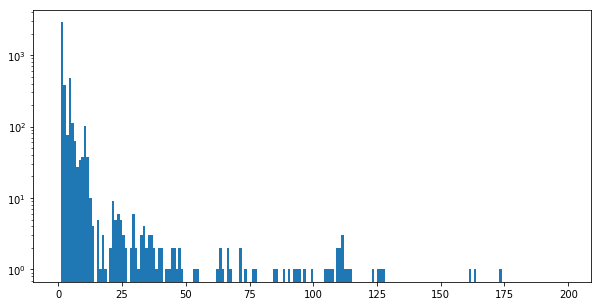

In [80]:
plt.figure(figsize=(10,5))
plt.hist(tt, bins=[i for i in range(200)], log=True)
plt.show()

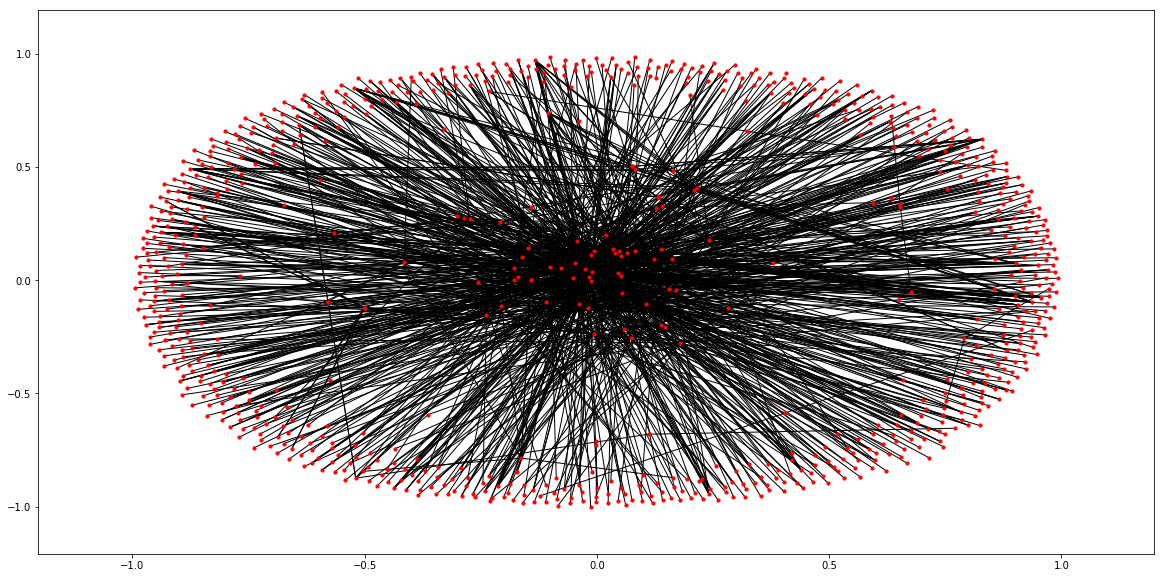

In [47]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(web_graph, with_labels=False, node_size=10, arrows=False)
plt.show()